In [1]:
'''Main'''
import numpy as np # linear algebra
import pandas as pd # data processing

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

'''Data Prep'''
from sklearn import preprocessing as pp # impute missing values, normalize data, etc.
from scipy.stats import pearsonr # calculate correlation matrix
from sklearn.model_selection import train_test_split # generate training and test sets
from sklearn.model_selection import StratifiedKFold # generate validation and test sets
from sklearn.metrics import log_loss # calculate log-loss (or cross entropy between the true labels and the predictions)
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report 

'''Algos'''
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
data = pd.read_csv('creditcard.csv')

In [3]:
data.shape

(284807, 31)

In [4]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [7]:
data['Class'].sum()

492

In [8]:
nanCounter = np.isnan(data).sum()

In [9]:
nanCounter

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [10]:
distinctCounter = data.apply(lambda x: len(x.unique()))

In [11]:
distinctCounter

Time      124592
V1        275663
V2        275663
V3        275663
V4        275663
V5        275663
V6        275663
V7        275663
V8        275663
V9        275663
V10       275663
V11       275663
V12       275663
V13       275663
V14       275663
V15       275663
V16       275663
V17       275663
V18       275663
V19       275663
V20       275663
V21       275663
V22       275663
V23       275663
V24       275663
V25       275663
V26       275663
V27       275663
V28       275663
Amount     32767
Class          2
dtype: int64

In [12]:
dataX = data.copy().drop(['Class'],axis=1)

In [13]:
dataY = data['Class'].copy()

In [14]:
featuresToScale = dataX.drop(['Time'],axis=1).columns

In [15]:
featuresToScale

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [16]:
sX = pp.StandardScaler(copy=True, with_mean=True, with_std=True)
dataX.loc[:,featuresToScale] = sX.fit_transform(dataX[featuresToScale])
scalingFactors = pd.DataFrame(data=[sX.mean_,sX.scale_],index=['Mean','StDev'],columns=featuresToScale)
#print("Mean and Standard Deviation by Feature: ",scalingFactors)

In [17]:
scalingFactors

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
Mean,1.165980e-15,3.416908e-16,-1.373150e-15,2.086869e-15,9.604066e-16,1.490107e-15,-5.556467e-16,1.177556e-16,-2.406455e-15,2.239751e-15,...,6.406703e-16,1.656562e-16,-3.444850e-16,2.578648e-16,4.471968e-15,5.340915e-16,1.687098e-15,-3.666453e-16,-1.220404e-16,88.349619
StDev,1.958692e+00,1.651306e+00,1.516252e+00,1.415866e+00,1.380244e+00,1.332269e+00,1.237091e+00,1.194351e+00,1.098630e+00,1.088848e+00,...,7.709237e-01,7.345227e-01,7.257003e-01,6.244592e-01,6.056460e-01,5.212772e-01,4.822262e-01,4.036318e-01,3.300827e-01,250.119670


In [18]:
dataX.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05
mean,94813.859575,-8.157366e-16,3.154853e-17,-4.409878e-15,-6.734811e-16,-2.874435e-16,4.168992e-16,-8.767997e-16,-2.423604e-16,3.078727e-16,...,2.754870e-16,1.685077e-17,1.478472e-15,-6.797197e-16,1.234659e-16,-7.659279e-16,3.247603e-16,-2.953495e-18,5.401572e-17,3.202236e-16
std,47488.145955,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00
min,0.000000,-2.879855e+01,-4.403529e+01,-3.187173e+01,-4.013919e+00,-8.240810e+01,-1.963606e+01,-3.520940e+01,-6.130252e+01,-1.222802e+01,...,-7.069146e+01,-4.741907e+01,-1.506565e+01,-7.175446e+01,-4.683638e+00,-1.975033e+01,-5.401098e+00,-5.590660e+01,-4.674612e+01,-3.532294e-01
25%,54201.500000,-4.698918e-01,-3.624707e-01,-5.872142e-01,-5.993788e-01,-5.010686e-01,-5.766822e-01,-4.478860e-01,-1.746805e-01,-5.853631e-01,...,-2.746334e-01,-3.109433e-01,-7.473476e-01,-2.591784e-01,-5.854676e-01,-6.084001e-01,-6.780717e-01,-1.755053e-01,-1.604440e-01,-3.308401e-01
50%,84692.000000,9.245351e-03,3.965683e-02,1.186124e-01,-1.401724e-02,-3.936682e-02,-2.058046e-01,3.241723e-02,1.871982e-02,-4.681169e-02,...,-8.104705e-02,-4.009429e-02,9.345377e-03,-1.792420e-02,6.765678e-02,3.183240e-02,-1.081217e-01,3.325174e-03,3.406368e-02,-2.652715e-01
75%,139320.500000,6.716939e-01,4.867202e-01,6.774569e-01,5.250082e-01,4.433465e-01,2.991625e-01,4.611107e-01,2.740785e-01,5.435305e-01,...,1.725733e-01,2.537392e-01,7.283360e-01,2.364319e-01,7.257153e-01,6.728006e-01,4.996663e-01,2.255648e-01,2.371526e-01,-4.471707e-02
max,172792.000000,1.253351e+00,1.335775e+01,6.187993e+00,1.191874e+01,2.521413e+01,5.502015e+01,9.747824e+01,1.675153e+01,1.419494e+01,...,5.113464e+01,3.703471e+01,1.447304e+01,3.607668e+01,7.569684e+00,1.442532e+01,7.293975e+00,7.831940e+01,1.025434e+02,1.023622e+02


In [19]:
correlationMatrix = pd.DataFrame(data=[],index=dataX.columns,columns=dataX.columns)
for i in dataX.columns:
    for j in dataX.columns:
        correlationMatrix.loc[i,j] = np.round(pearsonr(dataX.loc[:,i],dataX.loc[:,j])[0],2)

In [20]:
correlationMatrix.to_csv('correlationMatrix.csv')

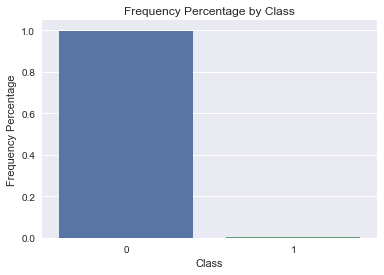

In [21]:
count_classes = pd.value_counts(data['Class'],sort=True).sort_index()
ax = sns.barplot(tuple(data.Class.unique()), tuple(count_classes/len(data)))
ax.set_title('Frequency Percentage by Class')
ax.set_xlabel('Class')
ax.set_ylabel('Frequency Percentage')

In [22]:
X_train, X_test, y_train, y_test = train_test_split(dataX, dataY, test_size=0.33, random_state=2018, stratify=dataY)

In [23]:
len(X_train)

190820

In [24]:
len(X_test)

93987

In [25]:
y_train.sum()/len(y_train)

0.0017293784718582959

In [26]:
y_test.sum()/len(y_test)

0.0017236426314277506

In [27]:
k_fold = StratifiedKFold(n_splits=5,shuffle=True,random_state=2018)

In [28]:
penalty = 'l2'
C = 1.0
class_weight = 'balanced'
random_state = 2018
solver = 'liblinear'
n_jobs = -1

logReg = LogisticRegression(penalty=penalty, C=C, class_weight=class_weight, 
                            random_state=random_state, solver=solver, n_jobs=n_jobs)

In [29]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

model = logReg

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLogisticRegression = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
print('Logistic Regression Log Loss: ', loglossLogisticRegression)

Training Log Loss:  0.103155487879
CV Log Loss:  0.108992523802
Training Log Loss:  0.108086544415
CV Log Loss:  0.103498371912
Training Log Loss:  0.0933784061194
CV Log Loss:  0.0950372744926
Training Log Loss:  0.117678342296
CV Log Loss:  0.118344289766
Training Log Loss:  0.1236933155
CV Log Loss:  0.121976305944
Logistic Regression Log Loss:  0.109569753183


In [30]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLogisticRegression = preds.copy()

In [31]:
precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])

In [32]:
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

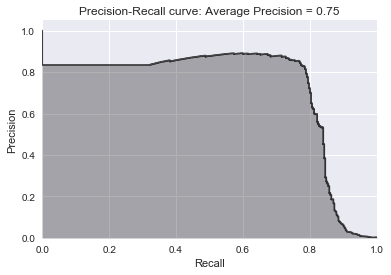

In [33]:
plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

In [34]:
fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])

In [35]:
areaUnderROC = auc(fpr, tpr)

In [36]:
#areaUnderROC_alternateVersion = roc_auc_score(preds['trueLabel'],preds['prediction']) #from the prediction probabilities directly

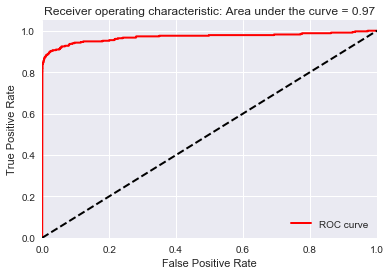

In [37]:
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [38]:
n_estimators = 10
max_features = 'auto'
max_depth = None
min_samples_split = 2
min_samples_leaf = 1
min_weight_fraction_leaf = 0.0
max_leaf_nodes = None
bootstrap = True
oob_score = False
n_jobs = -1
random_state = 2018
class_weight = 'balanced'

RFC = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth,
                             min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                             min_weight_fraction_leaf=min_weight_fraction_leaf, max_leaf_nodes=max_leaf_nodes,
                             bootstrap=bootstrap, oob_score=oob_score, n_jobs=n_jobs, random_state=random_state, 
                             class_weight=class_weight)

In [39]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=[0,1])

model = RFC

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    model.fit(X_train_fold, y_train_fold)
    loglossTraining = log_loss(y_train_fold, model.predict_proba(X_train_fold)[:,1])
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,:] = model.predict_proba(X_cv_fold)  
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,1])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossRandomForestsClassifier = log_loss(y_train, predictionsBasedOnKFolds.loc[:,1])
print('Random Forests Log Loss: ', loglossRandomForestsClassifier)

Training Log Loss:  0.000386664683241
CV Log Loss:  0.0153965105969
Training Log Loss:  0.000426321781737
CV Log Loss:  0.0107559537393
Training Log Loss:  0.000408833571195
CV Log Loss:  0.0153860563917
Training Log Loss:  0.000431025571857
CV Log Loss:  0.00476395856929
Training Log Loss:  0.000455960895651
CV Log Loss:  0.00561992122114
Random Forests Log Loss:  0.0103844801037


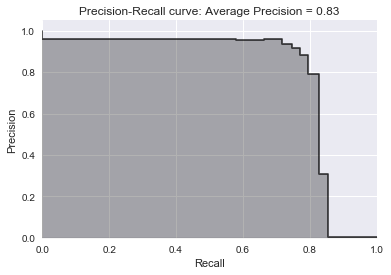

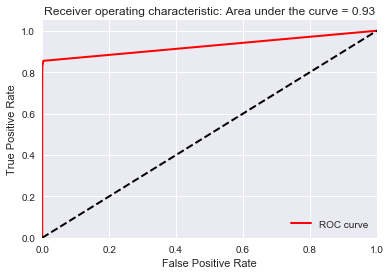

In [40]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,1]], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsRandomForests = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [41]:
params_xGB = {
    'nthread':16, #number of cores
    'learning rate': 0.3, #range 0 to 1, default 0.3
    'gamma': 0, #range 0 to infinity, default 0 // increase to reduce complexity (increase bias, reduce variance)
    'max_depth': 6, #range 1 to infinity, default 6
    'min_child_weight': 1, #range 0 to infinity, default 1
    'max_delta_step': 0, #range 0 to infinity, default 0
    'subsample': 1.0, #range 0 to 1, default 1 // subsample ratio of the training examples
    'colsample_bytree': 1.0, #range 0 to 1, default 1 // subsample ratio of features
    'objective':'binary:logistic',
    'num_class':1,
    'eval_metric':'logloss',
    'seed':2018,
    'silent':1
}

In [42]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    dtrain = xgb.DMatrix(data=X_train_fold, label=y_train_fold)
    dCV = xgb.DMatrix(data=X_cv_fold)
    
    bst = xgb.cv(params_xGB, dtrain, num_boost_round=2000, nfold=5, early_stopping_rounds=200, verbose_eval=50)
    
    best_rounds = np.argmin(bst['test-logloss-mean'])
    bst = xgb.train(params_xGB, dtrain, best_rounds)
    
    loglossTraining = log_loss(y_train_fold, bst.predict(dtrain))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = bst.predict(dCV)
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossXGBoostGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('XGBoost Gradient Boosting Log Loss: ', loglossXGBoostGradientBoosting)

[0]	train-logloss:0.437914+1.92395e-05	test-logloss:0.438049+8.19185e-05
[50]	train-logloss:0.0001304+8.06474e-06	test-logloss:0.0028826+0.000612192
[100]	train-logloss:5.48e-05+1.93907e-06	test-logloss:0.003116+0.000685626
[150]	train-logloss:4.1e-05+1.26491e-06	test-logloss:0.0032112+0.000711028
[200]	train-logloss:3.48e-05+7.48331e-07	test-logloss:0.0032666+0.000716546
Training Log Loss:  0.000665418756545
CV Log Loss:  0.00406178425351
[0]	train-logloss:0.437956+2.13073e-05	test-logloss:0.438073+1.47431e-05
[50]	train-logloss:0.0001394+6.18385e-06	test-logloss:0.003085+0.000514234
[100]	train-logloss:5.72e-05+1.72047e-06	test-logloss:0.0033678+0.000583955
[150]	train-logloss:4.28e-05+7.48331e-07	test-logloss:0.003466+0.000621204
[200]	train-logloss:3.6e-05+6.32456e-07	test-logloss:0.0035098+0.000618961
Training Log Loss:  0.000696737619242
CV Log Loss:  0.00300066343087
[0]	train-logloss:0.437913+1.21227e-05	test-logloss:0.438024+4.79458e-05
[50]	train-logloss:0.0001222+4.16653e-06

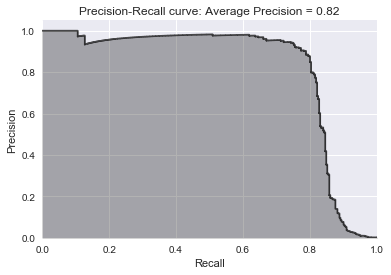

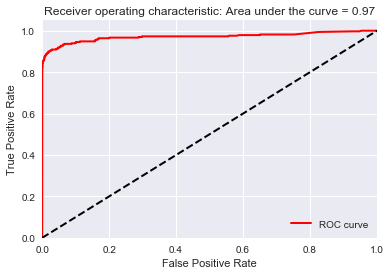

In [43]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsXGBoostGradientBoosting = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [44]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [45]:
trainingScores = []
cvScores = []
predictionsBasedOnKFolds = pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):
    X_train_fold, X_cv_fold = X_train.iloc[train_index,:], X_train.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFolds.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossLightGBMGradientBoosting = log_loss(y_train, predictionsBasedOnKFolds.loc[:,'prediction'])
print('LightGBM Gradient Boosting Log Loss: ', loglossLightGBMGradientBoosting)

[1]	valid_0's binary_logloss: 0.683221
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.673492
[3]	valid_0's binary_logloss: 0.663953
[4]	valid_0's binary_logloss: 0.654599
[5]	valid_0's binary_logloss: 0.645426
[6]	valid_0's binary_logloss: 0.636427
[7]	valid_0's binary_logloss: 0.627597
[8]	valid_0's binary_logloss: 0.618932
[9]	valid_0's binary_logloss: 0.610428
[10]	valid_0's binary_logloss: 0.602083
[11]	valid_0's binary_logloss: 0.59389
[12]	valid_0's binary_logloss: 0.585846
[13]	valid_0's binary_logloss: 0.577943
[14]	valid_0's binary_logloss: 0.570184
[15]	valid_0's binary_logloss: 0.562559
[16]	valid_0's binary_logloss: 0.555068
[17]	valid_0's binary_logloss: 0.54771
[18]	valid_0's binary_logloss: 0.540478
[19]	valid_0's binary_logloss: 0.53337
[20]	valid_0's binary_logloss: 0.526382
[21]	valid_0's binary_logloss: 0.519512
[22]	valid_0's binary_logloss: 0.512757
[23]	valid_0's binary_logloss: 0.506116
[24]	valid_0's binary_logloss

[212]	valid_0's binary_logloss: 0.0636855
[213]	valid_0's binary_logloss: 0.0630575
[214]	valid_0's binary_logloss: 0.0624364
[215]	valid_0's binary_logloss: 0.0618203
[216]	valid_0's binary_logloss: 0.0612123
[217]	valid_0's binary_logloss: 0.06061
[218]	valid_0's binary_logloss: 0.0600141
[219]	valid_0's binary_logloss: 0.0594253
[220]	valid_0's binary_logloss: 0.058843
[221]	valid_0's binary_logloss: 0.0582664
[222]	valid_0's binary_logloss: 0.0576958
[223]	valid_0's binary_logloss: 0.057131
[224]	valid_0's binary_logloss: 0.0565728
[225]	valid_0's binary_logloss: 0.0560199
[226]	valid_0's binary_logloss: 0.0554732
[227]	valid_0's binary_logloss: 0.0549326
[228]	valid_0's binary_logloss: 0.0543975
[229]	valid_0's binary_logloss: 0.0538674
[230]	valid_0's binary_logloss: 0.0533435
[231]	valid_0's binary_logloss: 0.0528252
[232]	valid_0's binary_logloss: 0.0523116
[233]	valid_0's binary_logloss: 0.0518044
[234]	valid_0's binary_logloss: 0.0513028
[235]	valid_0's binary_logloss: 0.0508

[417]	valid_0's binary_logloss: 0.0105503
[418]	valid_0's binary_logloss: 0.0104762
[419]	valid_0's binary_logloss: 0.0104037
[420]	valid_0's binary_logloss: 0.0103314
[421]	valid_0's binary_logloss: 0.0102605
[422]	valid_0's binary_logloss: 0.0101902
[423]	valid_0's binary_logloss: 0.0101191
[424]	valid_0's binary_logloss: 0.0100489
[425]	valid_0's binary_logloss: 0.00997925
[426]	valid_0's binary_logloss: 0.00991056
[427]	valid_0's binary_logloss: 0.00984322
[428]	valid_0's binary_logloss: 0.00977665
[429]	valid_0's binary_logloss: 0.00971059
[430]	valid_0's binary_logloss: 0.00964344
[431]	valid_0's binary_logloss: 0.00957714
[432]	valid_0's binary_logloss: 0.00951173
[433]	valid_0's binary_logloss: 0.00944832
[434]	valid_0's binary_logloss: 0.00938558
[435]	valid_0's binary_logloss: 0.00932309
[436]	valid_0's binary_logloss: 0.00926045
[437]	valid_0's binary_logloss: 0.00919999
[438]	valid_0's binary_logloss: 0.00913843
[439]	valid_0's binary_logloss: 0.0090792
[440]	valid_0's bina

[616]	valid_0's binary_logloss: 0.00437269
[617]	valid_0's binary_logloss: 0.00436466
[618]	valid_0's binary_logloss: 0.00435658
[619]	valid_0's binary_logloss: 0.00434869
[620]	valid_0's binary_logloss: 0.00434082
[621]	valid_0's binary_logloss: 0.00433291
[622]	valid_0's binary_logloss: 0.00432513
[623]	valid_0's binary_logloss: 0.00431741
[624]	valid_0's binary_logloss: 0.00430979
[625]	valid_0's binary_logloss: 0.00430235
[626]	valid_0's binary_logloss: 0.00429509
[627]	valid_0's binary_logloss: 0.0042877
[628]	valid_0's binary_logloss: 0.00428056
[629]	valid_0's binary_logloss: 0.00427358
[630]	valid_0's binary_logloss: 0.00426643
[631]	valid_0's binary_logloss: 0.00425931
[632]	valid_0's binary_logloss: 0.00425257
[633]	valid_0's binary_logloss: 0.00424602
[634]	valid_0's binary_logloss: 0.00423928
[635]	valid_0's binary_logloss: 0.00423172
[636]	valid_0's binary_logloss: 0.00422543
[637]	valid_0's binary_logloss: 0.004219
[638]	valid_0's binary_logloss: 0.00421248
[639]	valid_0'

[812]	valid_0's binary_logloss: 0.00380592
[813]	valid_0's binary_logloss: 0.00380525
[814]	valid_0's binary_logloss: 0.00380523
[815]	valid_0's binary_logloss: 0.00380565
[816]	valid_0's binary_logloss: 0.00380576
[817]	valid_0's binary_logloss: 0.00380686
[818]	valid_0's binary_logloss: 0.00380687
[819]	valid_0's binary_logloss: 0.00380645
[820]	valid_0's binary_logloss: 0.00380771
[821]	valid_0's binary_logloss: 0.00380744
[822]	valid_0's binary_logloss: 0.00380786
[823]	valid_0's binary_logloss: 0.00380787
[824]	valid_0's binary_logloss: 0.00380855
[825]	valid_0's binary_logloss: 0.00380859
[826]	valid_0's binary_logloss: 0.00380993
[827]	valid_0's binary_logloss: 0.0038104
[828]	valid_0's binary_logloss: 0.0038105
[829]	valid_0's binary_logloss: 0.00381002
[830]	valid_0's binary_logloss: 0.00381077
[831]	valid_0's binary_logloss: 0.00381145
[832]	valid_0's binary_logloss: 0.00381102
[833]	valid_0's binary_logloss: 0.00381036
[834]	valid_0's binary_logloss: 0.00381047
[835]	valid_0

[1005]	valid_0's binary_logloss: 0.00391966
[1006]	valid_0's binary_logloss: 0.00392127
[1007]	valid_0's binary_logloss: 0.00392273
[1008]	valid_0's binary_logloss: 0.00392515
[1009]	valid_0's binary_logloss: 0.00392571
[1010]	valid_0's binary_logloss: 0.00392734
[1011]	valid_0's binary_logloss: 0.00392791
[1012]	valid_0's binary_logloss: 0.00392913
[1013]	valid_0's binary_logloss: 0.00392961
[1014]	valid_0's binary_logloss: 0.00393125
Early stopping, best iteration is:
[814]	valid_0's binary_logloss: 0.00380523
Training Log Loss:  0.00110859401503
CV Log Loss:  0.00380522802074
[1]	valid_0's binary_logloss: 0.683217
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.673484
[3]	valid_0's binary_logloss: 0.663941
[4]	valid_0's binary_logloss: 0.654584
[5]	valid_0's binary_logloss: 0.645406
[6]	valid_0's binary_logloss: 0.636404
[7]	valid_0's binary_logloss: 0.627572
[8]	valid_0's binary_logloss: 0.618905
[9]	valid_0's binary_logloss: 0.610398


[200]	valid_0's binary_logloss: 0.0712885
[201]	valid_0's binary_logloss: 0.0705722
[202]	valid_0's binary_logloss: 0.0698639
[203]	valid_0's binary_logloss: 0.0691628
[204]	valid_0's binary_logloss: 0.0684687
[205]	valid_0's binary_logloss: 0.0677829
[206]	valid_0's binary_logloss: 0.0671042
[207]	valid_0's binary_logloss: 0.0664325
[208]	valid_0's binary_logloss: 0.0657684
[209]	valid_0's binary_logloss: 0.0651109
[210]	valid_0's binary_logloss: 0.06446
[211]	valid_0's binary_logloss: 0.0638166
[212]	valid_0's binary_logloss: 0.0631796
[213]	valid_0's binary_logloss: 0.0625491
[214]	valid_0's binary_logloss: 0.0619255
[215]	valid_0's binary_logloss: 0.0613089
[216]	valid_0's binary_logloss: 0.0606983
[217]	valid_0's binary_logloss: 0.0600943
[218]	valid_0's binary_logloss: 0.0594969
[219]	valid_0's binary_logloss: 0.0589057
[220]	valid_0's binary_logloss: 0.0583207
[221]	valid_0's binary_logloss: 0.0577418
[222]	valid_0's binary_logloss: 0.0571693
[223]	valid_0's binary_logloss: 0.05

[405]	valid_0's binary_logloss: 0.0107203
[406]	valid_0's binary_logloss: 0.0106353
[407]	valid_0's binary_logloss: 0.0105503
[408]	valid_0's binary_logloss: 0.0104664
[409]	valid_0's binary_logloss: 0.0103831
[410]	valid_0's binary_logloss: 0.0103012
[411]	valid_0's binary_logloss: 0.0102203
[412]	valid_0's binary_logloss: 0.0101397
[413]	valid_0's binary_logloss: 0.0100601
[414]	valid_0's binary_logloss: 0.00998128
[415]	valid_0's binary_logloss: 0.00990392
[416]	valid_0's binary_logloss: 0.00982688
[417]	valid_0's binary_logloss: 0.00975116
[418]	valid_0's binary_logloss: 0.00967571
[419]	valid_0's binary_logloss: 0.00960051
[420]	valid_0's binary_logloss: 0.00952666
[421]	valid_0's binary_logloss: 0.0094534
[422]	valid_0's binary_logloss: 0.00938103
[423]	valid_0's binary_logloss: 0.00930906
[424]	valid_0's binary_logloss: 0.00923754
[425]	valid_0's binary_logloss: 0.00916871
[426]	valid_0's binary_logloss: 0.00910059
[427]	valid_0's binary_logloss: 0.00903317
[428]	valid_0's binar

[602]	valid_0's binary_logloss: 0.0035963
[603]	valid_0's binary_logloss: 0.0035841
[604]	valid_0's binary_logloss: 0.00357418
[605]	valid_0's binary_logloss: 0.0035633
[606]	valid_0's binary_logloss: 0.00355284
[607]	valid_0's binary_logloss: 0.00354256
[608]	valid_0's binary_logloss: 0.00352824
[609]	valid_0's binary_logloss: 0.00351822
[610]	valid_0's binary_logloss: 0.00350474
[611]	valid_0's binary_logloss: 0.00349493
[612]	valid_0's binary_logloss: 0.00348558
[613]	valid_0's binary_logloss: 0.00347301
[614]	valid_0's binary_logloss: 0.00346376
[615]	valid_0's binary_logloss: 0.00345173
[616]	valid_0's binary_logloss: 0.00344242
[617]	valid_0's binary_logloss: 0.00343344
[618]	valid_0's binary_logloss: 0.00342463
[619]	valid_0's binary_logloss: 0.00341327
[620]	valid_0's binary_logloss: 0.00340466
[621]	valid_0's binary_logloss: 0.00339637
[622]	valid_0's binary_logloss: 0.00338771
[623]	valid_0's binary_logloss: 0.00337743
[624]	valid_0's binary_logloss: 0.00336932
[625]	valid_0'

[804]	valid_0's binary_logloss: 0.00278059
[805]	valid_0's binary_logloss: 0.0027802
[806]	valid_0's binary_logloss: 0.00277935
[807]	valid_0's binary_logloss: 0.00277864
[808]	valid_0's binary_logloss: 0.00277822
[809]	valid_0's binary_logloss: 0.00277825
[810]	valid_0's binary_logloss: 0.0027775
[811]	valid_0's binary_logloss: 0.0027777
[812]	valid_0's binary_logloss: 0.00277728
[813]	valid_0's binary_logloss: 0.00277702
[814]	valid_0's binary_logloss: 0.00277632
[815]	valid_0's binary_logloss: 0.00277566
[816]	valid_0's binary_logloss: 0.00277533
[817]	valid_0's binary_logloss: 0.00277471
[818]	valid_0's binary_logloss: 0.00277489
[819]	valid_0's binary_logloss: 0.00277517
[820]	valid_0's binary_logloss: 0.00277456
[821]	valid_0's binary_logloss: 0.00277426
[822]	valid_0's binary_logloss: 0.00277378
[823]	valid_0's binary_logloss: 0.00277323
[824]	valid_0's binary_logloss: 0.00277274
[825]	valid_0's binary_logloss: 0.00277283
[826]	valid_0's binary_logloss: 0.00277233
[827]	valid_0'

[997]	valid_0's binary_logloss: 0.00276796
[998]	valid_0's binary_logloss: 0.00276825
[999]	valid_0's binary_logloss: 0.00276859
[1000]	valid_0's binary_logloss: 0.00276898
[1001]	valid_0's binary_logloss: 0.00276856
[1002]	valid_0's binary_logloss: 0.00276923
[1003]	valid_0's binary_logloss: 0.0027695
[1004]	valid_0's binary_logloss: 0.00276999
[1005]	valid_0's binary_logloss: 0.00277023
[1006]	valid_0's binary_logloss: 0.00277054
[1007]	valid_0's binary_logloss: 0.0027698
[1008]	valid_0's binary_logloss: 0.00276985
[1009]	valid_0's binary_logloss: 0.00277054
[1010]	valid_0's binary_logloss: 0.00276981
[1011]	valid_0's binary_logloss: 0.00277016
[1012]	valid_0's binary_logloss: 0.00277015
[1013]	valid_0's binary_logloss: 0.00277056
[1014]	valid_0's binary_logloss: 0.00277096
[1015]	valid_0's binary_logloss: 0.00277129
[1016]	valid_0's binary_logloss: 0.0027713
[1017]	valid_0's binary_logloss: 0.0027718
[1018]	valid_0's binary_logloss: 0.00277182
[1019]	valid_0's binary_logloss: 0.0027

[54]	valid_0's binary_logloss: 0.344565
[55]	valid_0's binary_logloss: 0.340495
[56]	valid_0's binary_logloss: 0.336482
[57]	valid_0's binary_logloss: 0.332525
[58]	valid_0's binary_logloss: 0.328624
[59]	valid_0's binary_logloss: 0.324776
[60]	valid_0's binary_logloss: 0.320981
[61]	valid_0's binary_logloss: 0.317239
[62]	valid_0's binary_logloss: 0.313548
[63]	valid_0's binary_logloss: 0.309907
[64]	valid_0's binary_logloss: 0.306315
[65]	valid_0's binary_logloss: 0.302773
[66]	valid_0's binary_logloss: 0.299278
[67]	valid_0's binary_logloss: 0.295829
[68]	valid_0's binary_logloss: 0.292426
[69]	valid_0's binary_logloss: 0.28907
[70]	valid_0's binary_logloss: 0.285756
[71]	valid_0's binary_logloss: 0.28249
[72]	valid_0's binary_logloss: 0.279264
[73]	valid_0's binary_logloss: 0.27608
[74]	valid_0's binary_logloss: 0.27294
[75]	valid_0's binary_logloss: 0.269841
[76]	valid_0's binary_logloss: 0.266781
[77]	valid_0's binary_logloss: 0.263761
[78]	valid_0's binary_logloss: 0.260782
[79]

[257]	valid_0's binary_logloss: 0.0410595
[258]	valid_0's binary_logloss: 0.0406696
[259]	valid_0's binary_logloss: 0.0402822
[260]	valid_0's binary_logloss: 0.0398998
[261]	valid_0's binary_logloss: 0.0395217
[262]	valid_0's binary_logloss: 0.0391478
[263]	valid_0's binary_logloss: 0.0387779
[264]	valid_0's binary_logloss: 0.0384095
[265]	valid_0's binary_logloss: 0.0380456
[266]	valid_0's binary_logloss: 0.0376872
[267]	valid_0's binary_logloss: 0.0373323
[268]	valid_0's binary_logloss: 0.0369807
[269]	valid_0's binary_logloss: 0.0366316
[270]	valid_0's binary_logloss: 0.036286
[271]	valid_0's binary_logloss: 0.0359456
[272]	valid_0's binary_logloss: 0.0356068
[273]	valid_0's binary_logloss: 0.0352728
[274]	valid_0's binary_logloss: 0.0349432
[275]	valid_0's binary_logloss: 0.0346156
[276]	valid_0's binary_logloss: 0.0342925
[277]	valid_0's binary_logloss: 0.0339725
[278]	valid_0's binary_logloss: 0.0336563
[279]	valid_0's binary_logloss: 0.0333427
[280]	valid_0's binary_logloss: 0.0

[458]	valid_0's binary_logloss: 0.00800117
[459]	valid_0's binary_logloss: 0.00795207
[460]	valid_0's binary_logloss: 0.00790342
[461]	valid_0's binary_logloss: 0.00785538
[462]	valid_0's binary_logloss: 0.0078076
[463]	valid_0's binary_logloss: 0.00776039
[464]	valid_0's binary_logloss: 0.00771362
[465]	valid_0's binary_logloss: 0.00766762
[466]	valid_0's binary_logloss: 0.00762193
[467]	valid_0's binary_logloss: 0.00757774
[468]	valid_0's binary_logloss: 0.00753276
[469]	valid_0's binary_logloss: 0.00748858
[470]	valid_0's binary_logloss: 0.00744585
[471]	valid_0's binary_logloss: 0.00740252
[472]	valid_0's binary_logloss: 0.00735918
[473]	valid_0's binary_logloss: 0.00731748
[474]	valid_0's binary_logloss: 0.00727616
[475]	valid_0's binary_logloss: 0.00723489
[476]	valid_0's binary_logloss: 0.00719397
[477]	valid_0's binary_logloss: 0.00715353
[478]	valid_0's binary_logloss: 0.00711359
[479]	valid_0's binary_logloss: 0.00707361
[480]	valid_0's binary_logloss: 0.00703463
[481]	valid_

[655]	valid_0's binary_logloss: 0.00398572
[656]	valid_0's binary_logloss: 0.00397975
[657]	valid_0's binary_logloss: 0.00397461
[658]	valid_0's binary_logloss: 0.00396958
[659]	valid_0's binary_logloss: 0.00396376
[660]	valid_0's binary_logloss: 0.00395821
[661]	valid_0's binary_logloss: 0.0039534
[662]	valid_0's binary_logloss: 0.00394913
[663]	valid_0's binary_logloss: 0.00394367
[664]	valid_0's binary_logloss: 0.0039385
[665]	valid_0's binary_logloss: 0.00393218
[666]	valid_0's binary_logloss: 0.00392761
[667]	valid_0's binary_logloss: 0.00392244
[668]	valid_0's binary_logloss: 0.00391645
[669]	valid_0's binary_logloss: 0.00391216
[670]	valid_0's binary_logloss: 0.0039063
[671]	valid_0's binary_logloss: 0.00390262
[672]	valid_0's binary_logloss: 0.00389853
[673]	valid_0's binary_logloss: 0.00389377
[674]	valid_0's binary_logloss: 0.00388905
[675]	valid_0's binary_logloss: 0.00388381
[676]	valid_0's binary_logloss: 0.00387956
[677]	valid_0's binary_logloss: 0.00387446
[678]	valid_0'

[1045]	valid_0's binary_logloss: 0.0036895
[1046]	valid_0's binary_logloss: 0.00369047
[1047]	valid_0's binary_logloss: 0.00369104
[1048]	valid_0's binary_logloss: 0.00369199
[1049]	valid_0's binary_logloss: 0.00369245
[1050]	valid_0's binary_logloss: 0.00369342
[1051]	valid_0's binary_logloss: 0.00369398
[1052]	valid_0's binary_logloss: 0.00369384
[1053]	valid_0's binary_logloss: 0.00369357
[1054]	valid_0's binary_logloss: 0.00369401
[1055]	valid_0's binary_logloss: 0.00369424
[1056]	valid_0's binary_logloss: 0.0036941
[1057]	valid_0's binary_logloss: 0.00369451
[1058]	valid_0's binary_logloss: 0.00369436
[1059]	valid_0's binary_logloss: 0.00369486
[1060]	valid_0's binary_logloss: 0.00369546
[1061]	valid_0's binary_logloss: 0.00369573
[1062]	valid_0's binary_logloss: 0.00369682
[1063]	valid_0's binary_logloss: 0.00369656
[1064]	valid_0's binary_logloss: 0.00369663
[1065]	valid_0's binary_logloss: 0.0036967
[1066]	valid_0's binary_logloss: 0.00369787
[1067]	valid_0's binary_logloss: 0.

[165]	valid_0's binary_logloss: 0.101906
[166]	valid_0's binary_logloss: 0.100856
[167]	valid_0's binary_logloss: 0.0998173
[168]	valid_0's binary_logloss: 0.0987899
[169]	valid_0's binary_logloss: 0.0977745
[170]	valid_0's binary_logloss: 0.0967695
[171]	valid_0's binary_logloss: 0.0957757
[172]	valid_0's binary_logloss: 0.0947936
[173]	valid_0's binary_logloss: 0.0938213
[174]	valid_0's binary_logloss: 0.0928595
[175]	valid_0's binary_logloss: 0.0919091
[176]	valid_0's binary_logloss: 0.0909683
[177]	valid_0's binary_logloss: 0.0900384
[178]	valid_0's binary_logloss: 0.0891186
[179]	valid_0's binary_logloss: 0.0882085
[180]	valid_0's binary_logloss: 0.0873081
[181]	valid_0's binary_logloss: 0.0864184
[182]	valid_0's binary_logloss: 0.0855381
[183]	valid_0's binary_logloss: 0.0846671
[184]	valid_0's binary_logloss: 0.0838061
[185]	valid_0's binary_logloss: 0.0829535
[186]	valid_0's binary_logloss: 0.0821112
[187]	valid_0's binary_logloss: 0.0812772
[188]	valid_0's binary_logloss: 0.08

[377]	valid_0's binary_logloss: 0.0132869
[378]	valid_0's binary_logloss: 0.0131731
[379]	valid_0's binary_logloss: 0.0130603
[380]	valid_0's binary_logloss: 0.0129487
[381]	valid_0's binary_logloss: 0.0128381
[382]	valid_0's binary_logloss: 0.0127288
[383]	valid_0's binary_logloss: 0.0126206
[384]	valid_0's binary_logloss: 0.012513
[385]	valid_0's binary_logloss: 0.0124068
[386]	valid_0's binary_logloss: 0.0123019
[387]	valid_0's binary_logloss: 0.0121978
[388]	valid_0's binary_logloss: 0.0120945
[389]	valid_0's binary_logloss: 0.0119928
[390]	valid_0's binary_logloss: 0.0118919
[391]	valid_0's binary_logloss: 0.0117919
[392]	valid_0's binary_logloss: 0.0116927
[393]	valid_0's binary_logloss: 0.0115951
[394]	valid_0's binary_logloss: 0.0114982
[395]	valid_0's binary_logloss: 0.0114021
[396]	valid_0's binary_logloss: 0.0113072
[397]	valid_0's binary_logloss: 0.0112131
[398]	valid_0's binary_logloss: 0.0111198
[399]	valid_0's binary_logloss: 0.0110285
[400]	valid_0's binary_logloss: 0.0

[584]	valid_0's binary_logloss: 0.00336257
[585]	valid_0's binary_logloss: 0.00334811
[586]	valid_0's binary_logloss: 0.00333431
[587]	valid_0's binary_logloss: 0.00331983
[588]	valid_0's binary_logloss: 0.00330634
[589]	valid_0's binary_logloss: 0.00329251
[590]	valid_0's binary_logloss: 0.00327958
[591]	valid_0's binary_logloss: 0.00326597
[592]	valid_0's binary_logloss: 0.00325265
[593]	valid_0's binary_logloss: 0.00323969
[594]	valid_0's binary_logloss: 0.00322676
[595]	valid_0's binary_logloss: 0.00321382
[596]	valid_0's binary_logloss: 0.00320065
[597]	valid_0's binary_logloss: 0.00318792
[598]	valid_0's binary_logloss: 0.00317505
[599]	valid_0's binary_logloss: 0.00316306
[600]	valid_0's binary_logloss: 0.00315086
[601]	valid_0's binary_logloss: 0.0031384
[602]	valid_0's binary_logloss: 0.00312667
[603]	valid_0's binary_logloss: 0.00311495
[604]	valid_0's binary_logloss: 0.00310295
[605]	valid_0's binary_logloss: 0.00309146
[606]	valid_0's binary_logloss: 0.00308017
[607]	valid_

[784]	valid_0's binary_logloss: 0.00214242
[785]	valid_0's binary_logloss: 0.00214077
[786]	valid_0's binary_logloss: 0.00213935
[787]	valid_0's binary_logloss: 0.00213732
[788]	valid_0's binary_logloss: 0.00213526
[789]	valid_0's binary_logloss: 0.0021332
[790]	valid_0's binary_logloss: 0.00213166
[791]	valid_0's binary_logloss: 0.00213052
[792]	valid_0's binary_logloss: 0.00212802
[793]	valid_0's binary_logloss: 0.00212652
[794]	valid_0's binary_logloss: 0.00212505
[795]	valid_0's binary_logloss: 0.00212357
[796]	valid_0's binary_logloss: 0.00212178
[797]	valid_0's binary_logloss: 0.00212001
[798]	valid_0's binary_logloss: 0.00211862
[799]	valid_0's binary_logloss: 0.00211732
[800]	valid_0's binary_logloss: 0.00211546
[801]	valid_0's binary_logloss: 0.00211373
[802]	valid_0's binary_logloss: 0.00211179
[803]	valid_0's binary_logloss: 0.00211027
[804]	valid_0's binary_logloss: 0.00210869
[805]	valid_0's binary_logloss: 0.0021072
[806]	valid_0's binary_logloss: 0.00210533
[807]	valid_0

[980]	valid_0's binary_logloss: 0.00194188
[981]	valid_0's binary_logloss: 0.00194162
[982]	valid_0's binary_logloss: 0.00193972
[983]	valid_0's binary_logloss: 0.00194029
[984]	valid_0's binary_logloss: 0.00193865
[985]	valid_0's binary_logloss: 0.00193809
[986]	valid_0's binary_logloss: 0.00193767
[987]	valid_0's binary_logloss: 0.00193712
[988]	valid_0's binary_logloss: 0.00193734
[989]	valid_0's binary_logloss: 0.00193659
[990]	valid_0's binary_logloss: 0.00193666
[991]	valid_0's binary_logloss: 0.00193645
[992]	valid_0's binary_logloss: 0.00193561
[993]	valid_0's binary_logloss: 0.00193531
[994]	valid_0's binary_logloss: 0.00193499
[995]	valid_0's binary_logloss: 0.00193416
[996]	valid_0's binary_logloss: 0.0019346
[997]	valid_0's binary_logloss: 0.00193457
[998]	valid_0's binary_logloss: 0.00193454
[999]	valid_0's binary_logloss: 0.00193436
[1000]	valid_0's binary_logloss: 0.00193212
[1001]	valid_0's binary_logloss: 0.00193184
[1002]	valid_0's binary_logloss: 0.00193108
[1003]	va

[1172]	valid_0's binary_logloss: 0.00189462
[1173]	valid_0's binary_logloss: 0.00189453
[1174]	valid_0's binary_logloss: 0.00189472
[1175]	valid_0's binary_logloss: 0.00189432
[1176]	valid_0's binary_logloss: 0.00189385
[1177]	valid_0's binary_logloss: 0.00189396
[1178]	valid_0's binary_logloss: 0.00189399
[1179]	valid_0's binary_logloss: 0.0018943
[1180]	valid_0's binary_logloss: 0.00189359
[1181]	valid_0's binary_logloss: 0.00189309
[1182]	valid_0's binary_logloss: 0.00189249
[1183]	valid_0's binary_logloss: 0.00189272
[1184]	valid_0's binary_logloss: 0.00189315
[1185]	valid_0's binary_logloss: 0.00189299
[1186]	valid_0's binary_logloss: 0.00189335
[1187]	valid_0's binary_logloss: 0.00189317
[1188]	valid_0's binary_logloss: 0.00189268
[1189]	valid_0's binary_logloss: 0.00189282
[1190]	valid_0's binary_logloss: 0.00189271
[1191]	valid_0's binary_logloss: 0.00189308
[1192]	valid_0's binary_logloss: 0.00189297
[1193]	valid_0's binary_logloss: 0.00189286
[1194]	valid_0's binary_logloss: 

[1368]	valid_0's binary_logloss: 0.00186373
[1369]	valid_0's binary_logloss: 0.00186374
[1370]	valid_0's binary_logloss: 0.00186332
[1371]	valid_0's binary_logloss: 0.0018638
[1372]	valid_0's binary_logloss: 0.00186437
[1373]	valid_0's binary_logloss: 0.00186435
[1374]	valid_0's binary_logloss: 0.00186438
[1375]	valid_0's binary_logloss: 0.00186479
[1376]	valid_0's binary_logloss: 0.00186387
[1377]	valid_0's binary_logloss: 0.00186382
[1378]	valid_0's binary_logloss: 0.00186378
[1379]	valid_0's binary_logloss: 0.00186382
[1380]	valid_0's binary_logloss: 0.00186419
[1381]	valid_0's binary_logloss: 0.00186414
[1382]	valid_0's binary_logloss: 0.00186429
[1383]	valid_0's binary_logloss: 0.00186472
[1384]	valid_0's binary_logloss: 0.00186488
[1385]	valid_0's binary_logloss: 0.00186573
[1386]	valid_0's binary_logloss: 0.00186578
[1387]	valid_0's binary_logloss: 0.00186554
[1388]	valid_0's binary_logloss: 0.00186602
[1389]	valid_0's binary_logloss: 0.00186598
[1390]	valid_0's binary_logloss: 

[1556]	valid_0's binary_logloss: 0.00187017
[1557]	valid_0's binary_logloss: 0.00187053
[1558]	valid_0's binary_logloss: 0.00187096
[1559]	valid_0's binary_logloss: 0.00187115
[1560]	valid_0's binary_logloss: 0.00187096
[1561]	valid_0's binary_logloss: 0.00187011
[1562]	valid_0's binary_logloss: 0.00187047
[1563]	valid_0's binary_logloss: 0.00187055
[1564]	valid_0's binary_logloss: 0.00187004
[1565]	valid_0's binary_logloss: 0.00187009
[1566]	valid_0's binary_logloss: 0.00187046
[1567]	valid_0's binary_logloss: 0.0018709
[1568]	valid_0's binary_logloss: 0.00187003
[1569]	valid_0's binary_logloss: 0.00186985
[1570]	valid_0's binary_logloss: 0.00187023
Early stopping, best iteration is:
[1370]	valid_0's binary_logloss: 0.00186332
Training Log Loss:  0.000460260967292
CV Log Loss:  0.00186331815407
[1]	valid_0's binary_logloss: 0.683216
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.673482
[3]	valid_0's binary_logloss: 0.663939
[4]	valid_0's

[188]	valid_0's binary_logloss: 0.0803341
[189]	valid_0's binary_logloss: 0.0795164
[190]	valid_0's binary_logloss: 0.0787086
[191]	valid_0's binary_logloss: 0.0779087
[192]	valid_0's binary_logloss: 0.0771175
[193]	valid_0's binary_logloss: 0.0763346
[194]	valid_0's binary_logloss: 0.075561
[195]	valid_0's binary_logloss: 0.0747948
[196]	valid_0's binary_logloss: 0.0740363
[197]	valid_0's binary_logloss: 0.0732874
[198]	valid_0's binary_logloss: 0.0725454
[199]	valid_0's binary_logloss: 0.0718124
[200]	valid_0's binary_logloss: 0.0710869
[201]	valid_0's binary_logloss: 0.0703695
[202]	valid_0's binary_logloss: 0.0696594
[203]	valid_0's binary_logloss: 0.0689561
[204]	valid_0's binary_logloss: 0.0682615
[205]	valid_0's binary_logloss: 0.0675738
[206]	valid_0's binary_logloss: 0.0668927
[207]	valid_0's binary_logloss: 0.0662197
[208]	valid_0's binary_logloss: 0.0655535
[209]	valid_0's binary_logloss: 0.0648947
[210]	valid_0's binary_logloss: 0.0642429
[211]	valid_0's binary_logloss: 0.0

[392]	valid_0's binary_logloss: 0.0113956
[393]	valid_0's binary_logloss: 0.0112971
[394]	valid_0's binary_logloss: 0.0112001
[395]	valid_0's binary_logloss: 0.0111027
[396]	valid_0's binary_logloss: 0.0110071
[397]	valid_0's binary_logloss: 0.0109121
[398]	valid_0's binary_logloss: 0.0108189
[399]	valid_0's binary_logloss: 0.0107263
[400]	valid_0's binary_logloss: 0.0106342
[401]	valid_0's binary_logloss: 0.0105439
[402]	valid_0's binary_logloss: 0.0104541
[403]	valid_0's binary_logloss: 0.0103658
[404]	valid_0's binary_logloss: 0.0102782
[405]	valid_0's binary_logloss: 0.0101898
[406]	valid_0's binary_logloss: 0.0101041
[407]	valid_0's binary_logloss: 0.010018
[408]	valid_0's binary_logloss: 0.00993438
[409]	valid_0's binary_logloss: 0.00985098
[410]	valid_0's binary_logloss: 0.00976834
[411]	valid_0's binary_logloss: 0.0096863
[412]	valid_0's binary_logloss: 0.00960543
[413]	valid_0's binary_logloss: 0.0095254
[414]	valid_0's binary_logloss: 0.00944622
[415]	valid_0's binary_logloss

[592]	valid_0's binary_logloss: 0.00288794
[593]	valid_0's binary_logloss: 0.00287619
[594]	valid_0's binary_logloss: 0.00286364
[595]	valid_0's binary_logloss: 0.00285104
[596]	valid_0's binary_logloss: 0.00283879
[597]	valid_0's binary_logloss: 0.00282622
[598]	valid_0's binary_logloss: 0.00281488
[599]	valid_0's binary_logloss: 0.00280266
[600]	valid_0's binary_logloss: 0.00279068
[601]	valid_0's binary_logloss: 0.00277867
[602]	valid_0's binary_logloss: 0.00276665
[603]	valid_0's binary_logloss: 0.00275478
[604]	valid_0's binary_logloss: 0.00274316
[605]	valid_0's binary_logloss: 0.00273133
[606]	valid_0's binary_logloss: 0.00271984
[607]	valid_0's binary_logloss: 0.00270825
[608]	valid_0's binary_logloss: 0.00269714
[609]	valid_0's binary_logloss: 0.00268581
[610]	valid_0's binary_logloss: 0.00267461
[611]	valid_0's binary_logloss: 0.00266388
[612]	valid_0's binary_logloss: 0.00265364
[613]	valid_0's binary_logloss: 0.00264299
[614]	valid_0's binary_logloss: 0.00263228
[615]	valid

[794]	valid_0's binary_logloss: 0.00174474
[795]	valid_0's binary_logloss: 0.00174327
[796]	valid_0's binary_logloss: 0.00174125
[797]	valid_0's binary_logloss: 0.00173925
[798]	valid_0's binary_logloss: 0.00173677
[799]	valid_0's binary_logloss: 0.00173516
[800]	valid_0's binary_logloss: 0.00173318
[801]	valid_0's binary_logloss: 0.00173151
[802]	valid_0's binary_logloss: 0.00172943
[803]	valid_0's binary_logloss: 0.00172756
[804]	valid_0's binary_logloss: 0.00172555
[805]	valid_0's binary_logloss: 0.00172414
[806]	valid_0's binary_logloss: 0.00172236
[807]	valid_0's binary_logloss: 0.00172
[808]	valid_0's binary_logloss: 0.00171769
[809]	valid_0's binary_logloss: 0.00171599
[810]	valid_0's binary_logloss: 0.00171452
[811]	valid_0's binary_logloss: 0.0017131
[812]	valid_0's binary_logloss: 0.00171139
[813]	valid_0's binary_logloss: 0.00170991
[814]	valid_0's binary_logloss: 0.00170841
[815]	valid_0's binary_logloss: 0.00170653
[816]	valid_0's binary_logloss: 0.00170455
[817]	valid_0's

[988]	valid_0's binary_logloss: 0.00157906
[989]	valid_0's binary_logloss: 0.00157815
[990]	valid_0's binary_logloss: 0.00157795
[991]	valid_0's binary_logloss: 0.00157769
[992]	valid_0's binary_logloss: 0.00157675
[993]	valid_0's binary_logloss: 0.00157667
[994]	valid_0's binary_logloss: 0.00157649
[995]	valid_0's binary_logloss: 0.00157602
[996]	valid_0's binary_logloss: 0.00157604
[997]	valid_0's binary_logloss: 0.00157593
[998]	valid_0's binary_logloss: 0.00157575
[999]	valid_0's binary_logloss: 0.00157537
[1000]	valid_0's binary_logloss: 0.00157514
[1001]	valid_0's binary_logloss: 0.00157496
[1002]	valid_0's binary_logloss: 0.00157491
[1003]	valid_0's binary_logloss: 0.00157466
[1004]	valid_0's binary_logloss: 0.00157444
[1005]	valid_0's binary_logloss: 0.0015745
[1006]	valid_0's binary_logloss: 0.00157439
[1007]	valid_0's binary_logloss: 0.0015745
[1008]	valid_0's binary_logloss: 0.00157409
[1009]	valid_0's binary_logloss: 0.00157387
[1010]	valid_0's binary_logloss: 0.00157373
[1

[1179]	valid_0's binary_logloss: 0.00154781
[1180]	valid_0's binary_logloss: 0.00154748
[1181]	valid_0's binary_logloss: 0.00154617
[1182]	valid_0's binary_logloss: 0.00154566
[1183]	valid_0's binary_logloss: 0.00154562
[1184]	valid_0's binary_logloss: 0.00154514
[1185]	valid_0's binary_logloss: 0.00154524
[1186]	valid_0's binary_logloss: 0.00154522
[1187]	valid_0's binary_logloss: 0.00154501
[1188]	valid_0's binary_logloss: 0.0015455
[1189]	valid_0's binary_logloss: 0.00154605
[1190]	valid_0's binary_logloss: 0.00154548
[1191]	valid_0's binary_logloss: 0.00154471
[1192]	valid_0's binary_logloss: 0.00154421
[1193]	valid_0's binary_logloss: 0.0015445
[1194]	valid_0's binary_logloss: 0.0015444
[1195]	valid_0's binary_logloss: 0.0015441
[1196]	valid_0's binary_logloss: 0.00154417
[1197]	valid_0's binary_logloss: 0.00154377
[1198]	valid_0's binary_logloss: 0.00154373
[1199]	valid_0's binary_logloss: 0.00154393
[1200]	valid_0's binary_logloss: 0.00154406
[1201]	valid_0's binary_logloss: 0.0

[1373]	valid_0's binary_logloss: 0.00154111
[1374]	valid_0's binary_logloss: 0.00154073
[1375]	valid_0's binary_logloss: 0.00153989
[1376]	valid_0's binary_logloss: 0.00154019
[1377]	valid_0's binary_logloss: 0.00154017
[1378]	valid_0's binary_logloss: 0.00154005
[1379]	valid_0's binary_logloss: 0.00153941
[1380]	valid_0's binary_logloss: 0.00153949
[1381]	valid_0's binary_logloss: 0.00153956
[1382]	valid_0's binary_logloss: 0.00154005
[1383]	valid_0's binary_logloss: 0.00153993
[1384]	valid_0's binary_logloss: 0.00153913
[1385]	valid_0's binary_logloss: 0.00153921
[1386]	valid_0's binary_logloss: 0.00153889
[1387]	valid_0's binary_logloss: 0.00153849
[1388]	valid_0's binary_logloss: 0.00153831
[1389]	valid_0's binary_logloss: 0.00153911
[1390]	valid_0's binary_logloss: 0.00153875
[1391]	valid_0's binary_logloss: 0.00153836
[1392]	valid_0's binary_logloss: 0.00153783
[1393]	valid_0's binary_logloss: 0.00153782
[1394]	valid_0's binary_logloss: 0.00153791
[1395]	valid_0's binary_logloss:

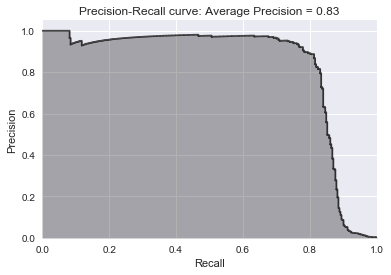

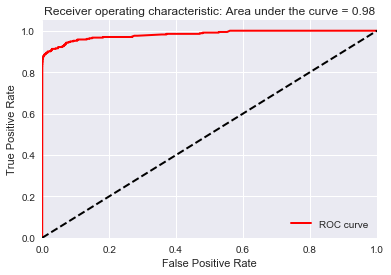

In [46]:
preds = pd.concat([y_train,predictionsBasedOnKFolds.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']
predictionsBasedOnKFoldsLightGBMGradientBoosting = preds.copy()

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [47]:
predictionsTestSetLogisticRegression = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLogisticRegression.loc[:,'prediction'] = logReg.predict_proba(X_test)[:,1]
logLossTestSetLogisticRegression = log_loss(y_test, predictionsTestSetLogisticRegression)

In [48]:
predictionsTestSetRandomForests = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetRandomForests.loc[:,'prediction'] = RFC.predict_proba(X_test)[:,1]
logLossTestSetRandomForests = log_loss(y_test, predictionsTestSetRandomForests)

In [49]:
predictionsTestSetXGBoostGradientBoosting = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
dtest = xgb.DMatrix(data=X_test)
predictionsTestSetXGBoostGradientBoosting.loc[:,'prediction'] = bst.predict(dtest)
logLossTestSetXGBoostGradientBoosting = log_loss(y_test, predictionsTestSetXGBoostGradientBoosting)

In [50]:
predictionsTestSetLightGBMGradientBoosting = pd.DataFrame(data=[],index=y_test.index,columns=['prediction'])
predictionsTestSetLightGBMGradientBoosting.loc[:,'prediction'] = gbm.predict(X_test, num_iteration=gbm.best_iteration)
logLossTestSetLightGBMGradientBoosting = log_loss(y_test, predictionsTestSetLightGBMGradientBoosting)

In [51]:
print("Log Loss of Logistic Regression on Test Set: ", logLossTestSetLogisticRegression)
print("Log Loss of Random Forests on Test Set: ", logLossTestSetRandomForests)
print("Log Loss of XGBoost Gradient Boosting on Test Set: ", logLossTestSetXGBoostGradientBoosting)
print("Log Loss of LightGBM Gradient Boosting on Test Set: ", logLossTestSetLightGBMGradientBoosting)

Log Loss of Logistic Regression on Test Set:  0.123732961313
Log Loss of Random Forests on Test Set:  0.00918192757674
Log Loss of XGBoost Gradient Boosting on Test Set:  0.00249116807943
Log Loss of LightGBM Gradient Boosting on Test Set:  0.00237632092424


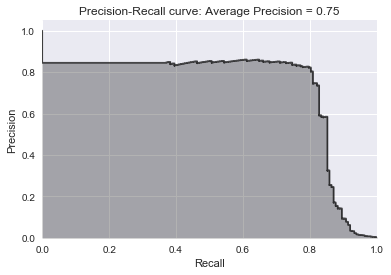

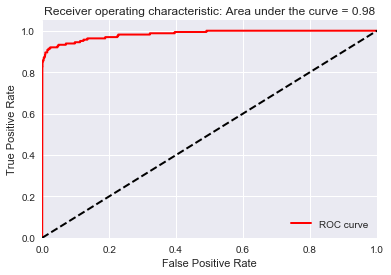

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetLogisticRegression)
average_precision = average_precision_score(y_test,predictionsTestSetLogisticRegression)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetLogisticRegression)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

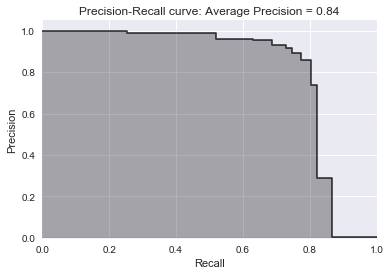

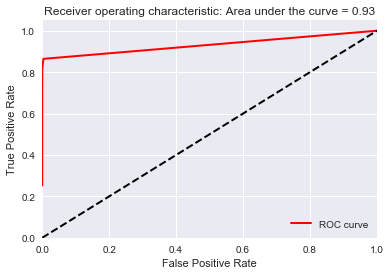

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetRandomForests)
average_precision = average_precision_score(y_test,predictionsTestSetRandomForests)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetRandomForests)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

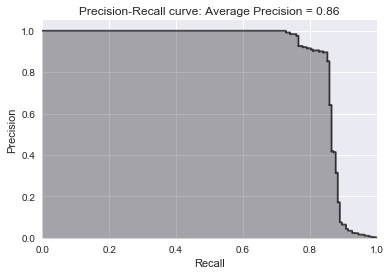

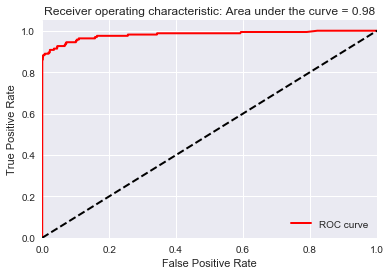

In [54]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
average_precision = average_precision_score(y_test,predictionsTestSetXGBoostGradientBoosting)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetXGBoostGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

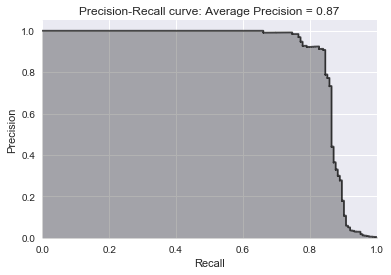

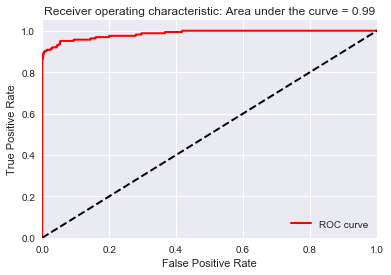

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
average_precision = average_precision_score(y_test,predictionsTestSetLightGBMGradientBoosting)

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(y_test,predictionsTestSetLightGBMGradientBoosting)
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

In [56]:
predictionsBasedOnKFoldsFourModels = pd.DataFrame(data=[],index=y_train.index)
predictionsBasedOnKFoldsFourModels = predictionsBasedOnKFoldsFourModels.join(
    predictionsBasedOnKFoldsLogisticRegression['prediction'].astype(float),how='left').join(
    predictionsBasedOnKFoldsRandomForests['prediction'].astype(float),how='left',rsuffix="2").join(
    predictionsBasedOnKFoldsXGBoostGradientBoosting['prediction'].astype(float),how='left',rsuffix="3").join(
    predictionsBasedOnKFoldsLightGBMGradientBoosting['prediction'].astype(float),how='left',rsuffix="4")
predictionsBasedOnKFoldsFourModels.columns = ['predsLR','predsRF','predsXGB','predsLightGBM']

In [57]:
X_trainWithPredictions = X_train.merge(predictionsBasedOnKFoldsFourModels,left_index=True,right_index=True)

In [58]:
params_lightGB = {
    'task': 'train',
    'application':'binary',
    'num_class':1,
    'boosting': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'metric_freq':50,
    'is_training_metric':False,
    'max_depth':4,
    'num_leaves': 31,
    'learning_rate': 0.01,
    'feature_fraction': 1.0,
    'bagging_fraction': 1.0,
    'bagging_freq': 0,
    'bagging_seed': 2018,
    'verbose': 0,
    'num_threads':16
}

In [59]:
trainingScores = []
cvScores = []
predictionsBasedOnKFoldsEnsemble = pd.DataFrame(data=[],index=y_train.index,columns=['prediction'])

for train_index, cv_index in k_fold.split(np.zeros(len(X_train)),y_train.ravel()):
    X_train_fold, X_cv_fold = X_trainWithPredictions.iloc[train_index,:], X_trainWithPredictions.iloc[cv_index,:]
    y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]
    
    lgb_train = lgb.Dataset(X_train_fold, y_train_fold)
    lgb_eval = lgb.Dataset(X_cv_fold, y_cv_fold, reference=lgb_train)
    gbm = lgb.train(params_lightGB, lgb_train, num_boost_round=2000,
                   valid_sets=lgb_eval, early_stopping_rounds=200)
    
    loglossTraining = log_loss(y_train_fold, gbm.predict(X_train_fold, num_iteration=gbm.best_iteration))
    trainingScores.append(loglossTraining)
    
    predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'] = gbm.predict(X_cv_fold, num_iteration=gbm.best_iteration) 
    loglossCV = log_loss(y_cv_fold, predictionsBasedOnKFoldsEnsemble.loc[X_cv_fold.index,'prediction'])
    cvScores.append(loglossCV)
    
    print('Training Log Loss: ', loglossTraining)
    print('CV Log Loss: ', loglossCV)
    
loglossEnsemble = log_loss(y_train, predictionsBasedOnKFoldsEnsemble.loc[:,'prediction'])
print('Ensemble Log Loss: ', loglossEnsemble)

[1]	valid_0's binary_logloss: 0.683219
Training until validation scores don't improve for 200 rounds.
[2]	valid_0's binary_logloss: 0.673488
[3]	valid_0's binary_logloss: 0.663947
[4]	valid_0's binary_logloss: 0.654592
[5]	valid_0's binary_logloss: 0.645416
[6]	valid_0's binary_logloss: 0.636415
[7]	valid_0's binary_logloss: 0.627584
[8]	valid_0's binary_logloss: 0.618919
[9]	valid_0's binary_logloss: 0.610413
[10]	valid_0's binary_logloss: 0.602066
[11]	valid_0's binary_logloss: 0.593869
[12]	valid_0's binary_logloss: 0.585821
[13]	valid_0's binary_logloss: 0.577918
[14]	valid_0's binary_logloss: 0.570156
[15]	valid_0's binary_logloss: 0.562531
[16]	valid_0's binary_logloss: 0.555039
[17]	valid_0's binary_logloss: 0.547679
[18]	valid_0's binary_logloss: 0.540444
[19]	valid_0's binary_logloss: 0.533334
[20]	valid_0's binary_logloss: 0.526345
[21]	valid_0's binary_logloss: 0.519474
[22]	valid_0's binary_logloss: 0.512718
[23]	valid_0's binary_logloss: 0.506076
[24]	valid_0's binary_logl

[204]	valid_0's binary_logloss: 0.0689875
[205]	valid_0's binary_logloss: 0.0683043
[206]	valid_0's binary_logloss: 0.0676268
[207]	valid_0's binary_logloss: 0.0669569
[208]	valid_0's binary_logloss: 0.0662946
[209]	valid_0's binary_logloss: 0.0656394
[210]	valid_0's binary_logloss: 0.0649913
[211]	valid_0's binary_logloss: 0.0643506
[212]	valid_0's binary_logloss: 0.0637153
[213]	valid_0's binary_logloss: 0.0630876
[214]	valid_0's binary_logloss: 0.0624667
[215]	valid_0's binary_logloss: 0.0618514
[216]	valid_0's binary_logloss: 0.0612441
[217]	valid_0's binary_logloss: 0.060643
[218]	valid_0's binary_logloss: 0.0600481
[219]	valid_0's binary_logloss: 0.0594587
[220]	valid_0's binary_logloss: 0.0588762
[221]	valid_0's binary_logloss: 0.0583007
[222]	valid_0's binary_logloss: 0.0577293
[223]	valid_0's binary_logloss: 0.0571642
[224]	valid_0's binary_logloss: 0.0566068
[225]	valid_0's binary_logloss: 0.0560536
[226]	valid_0's binary_logloss: 0.0555066
[227]	valid_0's binary_logloss: 0.0

[413]	valid_0's binary_logloss: 0.0109215
[414]	valid_0's binary_logloss: 0.0108444
[415]	valid_0's binary_logloss: 0.0107675
[416]	valid_0's binary_logloss: 0.0106929
[417]	valid_0's binary_logloss: 0.0106178
[418]	valid_0's binary_logloss: 0.0105443
[419]	valid_0's binary_logloss: 0.0104707
[420]	valid_0's binary_logloss: 0.0103988
[421]	valid_0's binary_logloss: 0.0103263
[422]	valid_0's binary_logloss: 0.0102553
[423]	valid_0's binary_logloss: 0.010184
[424]	valid_0's binary_logloss: 0.0101149
[425]	valid_0's binary_logloss: 0.010047
[426]	valid_0's binary_logloss: 0.00997936
[427]	valid_0's binary_logloss: 0.00991197
[428]	valid_0's binary_logloss: 0.00984498
[429]	valid_0's binary_logloss: 0.00977944
[430]	valid_0's binary_logloss: 0.00971465
[431]	valid_0's binary_logloss: 0.00965012
[432]	valid_0's binary_logloss: 0.00958639
[433]	valid_0's binary_logloss: 0.00952348
[434]	valid_0's binary_logloss: 0.00946087
[435]	valid_0's binary_logloss: 0.00939922
[436]	valid_0's binary_log

[609]	valid_0's binary_logloss: 0.00454584
[610]	valid_0's binary_logloss: 0.00453608
[611]	valid_0's binary_logloss: 0.00452744
[612]	valid_0's binary_logloss: 0.00451892
[613]	valid_0's binary_logloss: 0.00451027
[614]	valid_0's binary_logloss: 0.00450132
[615]	valid_0's binary_logloss: 0.00449302
[616]	valid_0's binary_logloss: 0.00448429
[617]	valid_0's binary_logloss: 0.00447573
[618]	valid_0's binary_logloss: 0.00446735
[619]	valid_0's binary_logloss: 0.00445936
[620]	valid_0's binary_logloss: 0.00445158
[621]	valid_0's binary_logloss: 0.0044433
[622]	valid_0's binary_logloss: 0.00443528
[623]	valid_0's binary_logloss: 0.00442742
[624]	valid_0's binary_logloss: 0.00441983
[625]	valid_0's binary_logloss: 0.00441232
[626]	valid_0's binary_logloss: 0.00440449
[627]	valid_0's binary_logloss: 0.0043963
[628]	valid_0's binary_logloss: 0.00438824
[629]	valid_0's binary_logloss: 0.00438023
[630]	valid_0's binary_logloss: 0.00437286
[631]	valid_0's binary_logloss: 0.00436607
[632]	valid_0

[810]	valid_0's binary_logloss: 0.00387701
[811]	valid_0's binary_logloss: 0.00387707
[812]	valid_0's binary_logloss: 0.00387739
[813]	valid_0's binary_logloss: 0.00387748
[814]	valid_0's binary_logloss: 0.0038769
[815]	valid_0's binary_logloss: 0.00387726
[816]	valid_0's binary_logloss: 0.00387743
[817]	valid_0's binary_logloss: 0.00387783
[818]	valid_0's binary_logloss: 0.00387755
[819]	valid_0's binary_logloss: 0.00387745
[820]	valid_0's binary_logloss: 0.00387717
[821]	valid_0's binary_logloss: 0.00387766
[822]	valid_0's binary_logloss: 0.00387742
[823]	valid_0's binary_logloss: 0.00387695
[824]	valid_0's binary_logloss: 0.00387751
[825]	valid_0's binary_logloss: 0.00387739
[826]	valid_0's binary_logloss: 0.00387722
[827]	valid_0's binary_logloss: 0.0038771
[828]	valid_0's binary_logloss: 0.00387692
[829]	valid_0's binary_logloss: 0.00387765
[830]	valid_0's binary_logloss: 0.00387661
[831]	valid_0's binary_logloss: 0.00387718
[832]	valid_0's binary_logloss: 0.00387707
[833]	valid_0

[1002]	valid_0's binary_logloss: 0.00392939
[1003]	valid_0's binary_logloss: 0.00393083
[1004]	valid_0's binary_logloss: 0.00393212
[1005]	valid_0's binary_logloss: 0.00393279
[1006]	valid_0's binary_logloss: 0.00393193
[1007]	valid_0's binary_logloss: 0.0039319
[1008]	valid_0's binary_logloss: 0.0039324
[1009]	valid_0's binary_logloss: 0.00393245
[1010]	valid_0's binary_logloss: 0.00393364
[1011]	valid_0's binary_logloss: 0.00393324
[1012]	valid_0's binary_logloss: 0.0039347
[1013]	valid_0's binary_logloss: 0.00393385
[1014]	valid_0's binary_logloss: 0.00393438
[1015]	valid_0's binary_logloss: 0.00393557
[1016]	valid_0's binary_logloss: 0.00393689
[1017]	valid_0's binary_logloss: 0.00393757
[1018]	valid_0's binary_logloss: 0.00393794
[1019]	valid_0's binary_logloss: 0.00393794
[1020]	valid_0's binary_logloss: 0.00393927
[1021]	valid_0's binary_logloss: 0.00393995
[1022]	valid_0's binary_logloss: 0.00393911
[1023]	valid_0's binary_logloss: 0.00393988
[1024]	valid_0's binary_logloss: 0.

[172]	valid_0's binary_logloss: 0.0947655
[173]	valid_0's binary_logloss: 0.0937944
[174]	valid_0's binary_logloss: 0.0928339
[175]	valid_0's binary_logloss: 0.0918838
[176]	valid_0's binary_logloss: 0.0909431
[177]	valid_0's binary_logloss: 0.0900138
[178]	valid_0's binary_logloss: 0.0890944
[179]	valid_0's binary_logloss: 0.0881856
[180]	valid_0's binary_logloss: 0.0872862
[181]	valid_0's binary_logloss: 0.0863958
[182]	valid_0's binary_logloss: 0.0855157
[183]	valid_0's binary_logloss: 0.0846456
[184]	valid_0's binary_logloss: 0.083785
[185]	valid_0's binary_logloss: 0.0829338
[186]	valid_0's binary_logloss: 0.0820913
[187]	valid_0's binary_logloss: 0.0812583
[188]	valid_0's binary_logloss: 0.080434
[189]	valid_0's binary_logloss: 0.0796188
[190]	valid_0's binary_logloss: 0.0788124
[191]	valid_0's binary_logloss: 0.0780149
[192]	valid_0's binary_logloss: 0.077226
[193]	valid_0's binary_logloss: 0.0764451
[194]	valid_0's binary_logloss: 0.0756728
[195]	valid_0's binary_logloss: 0.074

[380]	valid_0's binary_logloss: 0.0131276
[381]	valid_0's binary_logloss: 0.013018
[382]	valid_0's binary_logloss: 0.0129098
[383]	valid_0's binary_logloss: 0.0128024
[384]	valid_0's binary_logloss: 0.0126958
[385]	valid_0's binary_logloss: 0.0125908
[386]	valid_0's binary_logloss: 0.0124868
[387]	valid_0's binary_logloss: 0.0123836
[388]	valid_0's binary_logloss: 0.0122813
[389]	valid_0's binary_logloss: 0.0121806
[390]	valid_0's binary_logloss: 0.0120811
[391]	valid_0's binary_logloss: 0.0119824
[392]	valid_0's binary_logloss: 0.0118844
[393]	valid_0's binary_logloss: 0.0117877
[394]	valid_0's binary_logloss: 0.0116919
[395]	valid_0's binary_logloss: 0.0115973
[396]	valid_0's binary_logloss: 0.0115033
[397]	valid_0's binary_logloss: 0.0114104
[398]	valid_0's binary_logloss: 0.0113186
[399]	valid_0's binary_logloss: 0.0112275
[400]	valid_0's binary_logloss: 0.0111377
[401]	valid_0's binary_logloss: 0.0110485
[402]	valid_0's binary_logloss: 0.0109608
[403]	valid_0's binary_logloss: 0.0

[587]	valid_0's binary_logloss: 0.00381007
[588]	valid_0's binary_logloss: 0.00379797
[589]	valid_0's binary_logloss: 0.0037862
[590]	valid_0's binary_logloss: 0.00377504
[591]	valid_0's binary_logloss: 0.00376349
[592]	valid_0's binary_logloss: 0.00375197
[593]	valid_0's binary_logloss: 0.00374134
[594]	valid_0's binary_logloss: 0.00373005
[595]	valid_0's binary_logloss: 0.00371909
[596]	valid_0's binary_logloss: 0.00370826
[597]	valid_0's binary_logloss: 0.00369738
[598]	valid_0's binary_logloss: 0.0036868
[599]	valid_0's binary_logloss: 0.003677
[600]	valid_0's binary_logloss: 0.00366661
[601]	valid_0's binary_logloss: 0.00365648
[602]	valid_0's binary_logloss: 0.00364671
[603]	valid_0's binary_logloss: 0.00363677
[604]	valid_0's binary_logloss: 0.00362713
[605]	valid_0's binary_logloss: 0.00361738
[606]	valid_0's binary_logloss: 0.00360789
[607]	valid_0's binary_logloss: 0.0035982
[608]	valid_0's binary_logloss: 0.0035888
[609]	valid_0's binary_logloss: 0.00357967
[610]	valid_0's b

[785]	valid_0's binary_logloss: 0.00295329
[786]	valid_0's binary_logloss: 0.00295315
[787]	valid_0's binary_logloss: 0.0029539
[788]	valid_0's binary_logloss: 0.00295479
[789]	valid_0's binary_logloss: 0.00295398
[790]	valid_0's binary_logloss: 0.00295423
[791]	valid_0's binary_logloss: 0.00295361
[792]	valid_0's binary_logloss: 0.00295359
[793]	valid_0's binary_logloss: 0.00295347
[794]	valid_0's binary_logloss: 0.00295311
[795]	valid_0's binary_logloss: 0.00295397
[796]	valid_0's binary_logloss: 0.00295342
[797]	valid_0's binary_logloss: 0.00295281
[798]	valid_0's binary_logloss: 0.00295222
[799]	valid_0's binary_logloss: 0.00295152
[800]	valid_0's binary_logloss: 0.00295041
[801]	valid_0's binary_logloss: 0.00294928
[802]	valid_0's binary_logloss: 0.00294823
[803]	valid_0's binary_logloss: 0.00294715
[804]	valid_0's binary_logloss: 0.00294636
[805]	valid_0's binary_logloss: 0.00294532
[806]	valid_0's binary_logloss: 0.00294396
[807]	valid_0's binary_logloss: 0.00294313
[808]	valid_

[984]	valid_0's binary_logloss: 0.00293198
[985]	valid_0's binary_logloss: 0.00293198
[986]	valid_0's binary_logloss: 0.00293216
[987]	valid_0's binary_logloss: 0.00293274
[988]	valid_0's binary_logloss: 0.00293235
[989]	valid_0's binary_logloss: 0.00293245
[990]	valid_0's binary_logloss: 0.00293256
[991]	valid_0's binary_logloss: 0.00293272
[992]	valid_0's binary_logloss: 0.00293337
[993]	valid_0's binary_logloss: 0.00293379
[994]	valid_0's binary_logloss: 0.00293409
[995]	valid_0's binary_logloss: 0.0029346
[996]	valid_0's binary_logloss: 0.00293517
[997]	valid_0's binary_logloss: 0.00293477
[998]	valid_0's binary_logloss: 0.00293496
[999]	valid_0's binary_logloss: 0.00293654
[1000]	valid_0's binary_logloss: 0.00293731
[1001]	valid_0's binary_logloss: 0.00293764
[1002]	valid_0's binary_logloss: 0.00293739
[1003]	valid_0's binary_logloss: 0.00293776
[1004]	valid_0's binary_logloss: 0.00293767
[1005]	valid_0's binary_logloss: 0.00293728
[1006]	valid_0's binary_logloss: 0.00293877
[1007

[75]	valid_0's binary_logloss: 0.269711
[76]	valid_0's binary_logloss: 0.266652
[77]	valid_0's binary_logloss: 0.263632
[78]	valid_0's binary_logloss: 0.260651
[79]	valid_0's binary_logloss: 0.25771
[80]	valid_0's binary_logloss: 0.254806
[81]	valid_0's binary_logloss: 0.251939
[82]	valid_0's binary_logloss: 0.249109
[83]	valid_0's binary_logloss: 0.246315
[84]	valid_0's binary_logloss: 0.243557
[85]	valid_0's binary_logloss: 0.240834
[86]	valid_0's binary_logloss: 0.238146
[87]	valid_0's binary_logloss: 0.235492
[88]	valid_0's binary_logloss: 0.232871
[89]	valid_0's binary_logloss: 0.230283
[90]	valid_0's binary_logloss: 0.227728
[91]	valid_0's binary_logloss: 0.225204
[92]	valid_0's binary_logloss: 0.222713
[93]	valid_0's binary_logloss: 0.220251
[94]	valid_0's binary_logloss: 0.217821
[95]	valid_0's binary_logloss: 0.215421
[96]	valid_0's binary_logloss: 0.21305
[97]	valid_0's binary_logloss: 0.210709
[98]	valid_0's binary_logloss: 0.208397
[99]	valid_0's binary_logloss: 0.206113
[1

[289]	valid_0's binary_logloss: 0.0303117
[290]	valid_0's binary_logloss: 0.0300339
[291]	valid_0's binary_logloss: 0.0297578
[292]	valid_0's binary_logloss: 0.0294845
[293]	valid_0's binary_logloss: 0.0292139
[294]	valid_0's binary_logloss: 0.0289478
[295]	valid_0's binary_logloss: 0.0286828
[296]	valid_0's binary_logloss: 0.0284202
[297]	valid_0's binary_logloss: 0.0281604
[298]	valid_0's binary_logloss: 0.027904
[299]	valid_0's binary_logloss: 0.0276496
[300]	valid_0's binary_logloss: 0.0273989
[301]	valid_0's binary_logloss: 0.0271497
[302]	valid_0's binary_logloss: 0.0269043
[303]	valid_0's binary_logloss: 0.0266599
[304]	valid_0's binary_logloss: 0.0264197
[305]	valid_0's binary_logloss: 0.0261807
[306]	valid_0's binary_logloss: 0.0259446
[307]	valid_0's binary_logloss: 0.0257098
[308]	valid_0's binary_logloss: 0.0254791
[309]	valid_0's binary_logloss: 0.0252498
[310]	valid_0's binary_logloss: 0.025023
[311]	valid_0's binary_logloss: 0.0247998
[312]	valid_0's binary_logloss: 0.02

[498]	valid_0's binary_logloss: 0.00638883
[499]	valid_0's binary_logloss: 0.0063578
[500]	valid_0's binary_logloss: 0.00632652
[501]	valid_0's binary_logloss: 0.00629593
[502]	valid_0's binary_logloss: 0.00626569
[503]	valid_0's binary_logloss: 0.00623584
[504]	valid_0's binary_logloss: 0.00620596
[505]	valid_0's binary_logloss: 0.00617599
[506]	valid_0's binary_logloss: 0.00614559
[507]	valid_0's binary_logloss: 0.00611692
[508]	valid_0's binary_logloss: 0.00608867
[509]	valid_0's binary_logloss: 0.00606048
[510]	valid_0's binary_logloss: 0.00603214
[511]	valid_0's binary_logloss: 0.00600413
[512]	valid_0's binary_logloss: 0.005977
[513]	valid_0's binary_logloss: 0.00595025
[514]	valid_0's binary_logloss: 0.00592307
[515]	valid_0's binary_logloss: 0.0058963
[516]	valid_0's binary_logloss: 0.00586967
[517]	valid_0's binary_logloss: 0.00584416
[518]	valid_0's binary_logloss: 0.00581824
[519]	valid_0's binary_logloss: 0.00579292
[520]	valid_0's binary_logloss: 0.00576786
[521]	valid_0's

[704]	valid_0's binary_logloss: 0.00387736
[705]	valid_0's binary_logloss: 0.00387496
[706]	valid_0's binary_logloss: 0.00387295
[707]	valid_0's binary_logloss: 0.00387063
[708]	valid_0's binary_logloss: 0.00386839
[709]	valid_0's binary_logloss: 0.00386618
[710]	valid_0's binary_logloss: 0.0038641
[711]	valid_0's binary_logloss: 0.00386233
[712]	valid_0's binary_logloss: 0.00386033
[713]	valid_0's binary_logloss: 0.00385829
[714]	valid_0's binary_logloss: 0.00385716
[715]	valid_0's binary_logloss: 0.00385519
[716]	valid_0's binary_logloss: 0.00385326
[717]	valid_0's binary_logloss: 0.00385137
[718]	valid_0's binary_logloss: 0.00384972
[719]	valid_0's binary_logloss: 0.00384791
[720]	valid_0's binary_logloss: 0.00384606
[721]	valid_0's binary_logloss: 0.0038444
[722]	valid_0's binary_logloss: 0.00384277
[723]	valid_0's binary_logloss: 0.00384084
[724]	valid_0's binary_logloss: 0.00383989
[725]	valid_0's binary_logloss: 0.0038383
[726]	valid_0's binary_logloss: 0.00383633
[727]	valid_0'

[898]	valid_0's binary_logloss: 0.00377357
[899]	valid_0's binary_logloss: 0.00377446
[900]	valid_0's binary_logloss: 0.00377563
[901]	valid_0's binary_logloss: 0.00377654
[902]	valid_0's binary_logloss: 0.00377756
[903]	valid_0's binary_logloss: 0.00377847
[904]	valid_0's binary_logloss: 0.00377967
[905]	valid_0's binary_logloss: 0.00377927
[906]	valid_0's binary_logloss: 0.00377889
[907]	valid_0's binary_logloss: 0.00377928
[908]	valid_0's binary_logloss: 0.0037805
[909]	valid_0's binary_logloss: 0.00378013
[910]	valid_0's binary_logloss: 0.00377978
[911]	valid_0's binary_logloss: 0.00378101
[912]	valid_0's binary_logloss: 0.00378088
[913]	valid_0's binary_logloss: 0.00378073
[914]	valid_0's binary_logloss: 0.0037817
[915]	valid_0's binary_logloss: 0.00378137
[916]	valid_0's binary_logloss: 0.00378282
[917]	valid_0's binary_logloss: 0.00378348
[918]	valid_0's binary_logloss: 0.00378317
[919]	valid_0's binary_logloss: 0.00378384
[920]	valid_0's binary_logloss: 0.00378524
[921]	valid_0

[57]	valid_0's binary_logloss: 0.332246
[58]	valid_0's binary_logloss: 0.328341
[59]	valid_0's binary_logloss: 0.32449
[60]	valid_0's binary_logloss: 0.320691
[61]	valid_0's binary_logloss: 0.316945
[62]	valid_0's binary_logloss: 0.31325
[63]	valid_0's binary_logloss: 0.309606
[64]	valid_0's binary_logloss: 0.30601
[65]	valid_0's binary_logloss: 0.302464
[66]	valid_0's binary_logloss: 0.298966
[67]	valid_0's binary_logloss: 0.295514
[68]	valid_0's binary_logloss: 0.292109
[69]	valid_0's binary_logloss: 0.288749
[70]	valid_0's binary_logloss: 0.285434
[71]	valid_0's binary_logloss: 0.282163
[72]	valid_0's binary_logloss: 0.278934
[73]	valid_0's binary_logloss: 0.275749
[74]	valid_0's binary_logloss: 0.272605
[75]	valid_0's binary_logloss: 0.269503
[76]	valid_0's binary_logloss: 0.266441
[77]	valid_0's binary_logloss: 0.263418
[78]	valid_0's binary_logloss: 0.260436
[79]	valid_0's binary_logloss: 0.257491
[80]	valid_0's binary_logloss: 0.254585
[81]	valid_0's binary_logloss: 0.251715
[82

[261]	valid_0's binary_logloss: 0.0387173
[262]	valid_0's binary_logloss: 0.0383414
[263]	valid_0's binary_logloss: 0.0379691
[264]	valid_0's binary_logloss: 0.0375996
[265]	valid_0's binary_logloss: 0.0372351
[266]	valid_0's binary_logloss: 0.0368745
[267]	valid_0's binary_logloss: 0.0365164
[268]	valid_0's binary_logloss: 0.0361631
[269]	valid_0's binary_logloss: 0.0358122
[270]	valid_0's binary_logloss: 0.0354651
[271]	valid_0's binary_logloss: 0.0351229
[272]	valid_0's binary_logloss: 0.0347842
[273]	valid_0's binary_logloss: 0.034448
[274]	valid_0's binary_logloss: 0.0341161
[275]	valid_0's binary_logloss: 0.0337881
[276]	valid_0's binary_logloss: 0.0334615
[277]	valid_0's binary_logloss: 0.033139
[278]	valid_0's binary_logloss: 0.032821
[279]	valid_0's binary_logloss: 0.0325055
[280]	valid_0's binary_logloss: 0.0321926
[281]	valid_0's binary_logloss: 0.0318839
[282]	valid_0's binary_logloss: 0.0315776
[283]	valid_0's binary_logloss: 0.0312755
[284]	valid_0's binary_logloss: 0.030

[456]	valid_0's binary_logloss: 0.00687673
[457]	valid_0's binary_logloss: 0.00682624
[458]	valid_0's binary_logloss: 0.00677613
[459]	valid_0's binary_logloss: 0.00672656
[460]	valid_0's binary_logloss: 0.00667699
[461]	valid_0's binary_logloss: 0.00662833
[462]	valid_0's binary_logloss: 0.00658009
[463]	valid_0's binary_logloss: 0.00653242
[464]	valid_0's binary_logloss: 0.00648471
[465]	valid_0's binary_logloss: 0.00643741
[466]	valid_0's binary_logloss: 0.00639069
[467]	valid_0's binary_logloss: 0.00634511
[468]	valid_0's binary_logloss: 0.00630005
[469]	valid_0's binary_logloss: 0.00625506
[470]	valid_0's binary_logloss: 0.00621025
[471]	valid_0's binary_logloss: 0.00616592
[472]	valid_0's binary_logloss: 0.00612212
[473]	valid_0's binary_logloss: 0.00607943
[474]	valid_0's binary_logloss: 0.00603688
[475]	valid_0's binary_logloss: 0.00599429
[476]	valid_0's binary_logloss: 0.00595308
[477]	valid_0's binary_logloss: 0.00591177
[478]	valid_0's binary_logloss: 0.00587048
[479]	valid

[650]	valid_0's binary_logloss: 0.00257917
[651]	valid_0's binary_logloss: 0.00257198
[652]	valid_0's binary_logloss: 0.00256529
[653]	valid_0's binary_logloss: 0.00255781
[654]	valid_0's binary_logloss: 0.00255096
[655]	valid_0's binary_logloss: 0.00254383
[656]	valid_0's binary_logloss: 0.00253675
[657]	valid_0's binary_logloss: 0.00253018
[658]	valid_0's binary_logloss: 0.00252415
[659]	valid_0's binary_logloss: 0.00251727
[660]	valid_0's binary_logloss: 0.0025105
[661]	valid_0's binary_logloss: 0.00250379
[662]	valid_0's binary_logloss: 0.0024972
[663]	valid_0's binary_logloss: 0.00249108
[664]	valid_0's binary_logloss: 0.00248509
[665]	valid_0's binary_logloss: 0.00247955
[666]	valid_0's binary_logloss: 0.00247373
[667]	valid_0's binary_logloss: 0.00246829
[668]	valid_0's binary_logloss: 0.00246261
[669]	valid_0's binary_logloss: 0.00245739
[670]	valid_0's binary_logloss: 0.0024517
[671]	valid_0's binary_logloss: 0.00244615
[672]	valid_0's binary_logloss: 0.00244109
[673]	valid_0'

[842]	valid_0's binary_logloss: 0.00198965
[843]	valid_0's binary_logloss: 0.00198838
[844]	valid_0's binary_logloss: 0.00198712
[845]	valid_0's binary_logloss: 0.00198587
[846]	valid_0's binary_logloss: 0.00198473
[847]	valid_0's binary_logloss: 0.00198351
[848]	valid_0's binary_logloss: 0.00198231
[849]	valid_0's binary_logloss: 0.00198112
[850]	valid_0's binary_logloss: 0.00198022
[851]	valid_0's binary_logloss: 0.00197906
[852]	valid_0's binary_logloss: 0.00197791
[853]	valid_0's binary_logloss: 0.00197732
[854]	valid_0's binary_logloss: 0.0019762
[855]	valid_0's binary_logloss: 0.00197509
[856]	valid_0's binary_logloss: 0.00197424
[857]	valid_0's binary_logloss: 0.00197316
[858]	valid_0's binary_logloss: 0.00197179
[859]	valid_0's binary_logloss: 0.00197072
[860]	valid_0's binary_logloss: 0.00196939
[861]	valid_0's binary_logloss: 0.00196806
[862]	valid_0's binary_logloss: 0.00196704
[863]	valid_0's binary_logloss: 0.00196574
[864]	valid_0's binary_logloss: 0.0019647
[865]	valid_0

[1041]	valid_0's binary_logloss: 0.00189333
[1042]	valid_0's binary_logloss: 0.00189325
[1043]	valid_0's binary_logloss: 0.00189225
[1044]	valid_0's binary_logloss: 0.00189165
[1045]	valid_0's binary_logloss: 0.00189197
[1046]	valid_0's binary_logloss: 0.00189205
[1047]	valid_0's binary_logloss: 0.00189167
[1048]	valid_0's binary_logloss: 0.00189116
[1049]	valid_0's binary_logloss: 0.00189051
[1050]	valid_0's binary_logloss: 0.00189006
[1051]	valid_0's binary_logloss: 0.00189027
[1052]	valid_0's binary_logloss: 0.00188937
[1053]	valid_0's binary_logloss: 0.00188799
[1054]	valid_0's binary_logloss: 0.00188755
[1055]	valid_0's binary_logloss: 0.00188751
[1056]	valid_0's binary_logloss: 0.00188663
[1057]	valid_0's binary_logloss: 0.00188504
[1058]	valid_0's binary_logloss: 0.00188435
[1059]	valid_0's binary_logloss: 0.00188399
[1060]	valid_0's binary_logloss: 0.00188313
[1061]	valid_0's binary_logloss: 0.0018816
[1062]	valid_0's binary_logloss: 0.00188149
[1063]	valid_0's binary_logloss: 

[1239]	valid_0's binary_logloss: 0.00185146
[1240]	valid_0's binary_logloss: 0.00185154
[1241]	valid_0's binary_logloss: 0.00185124
[1242]	valid_0's binary_logloss: 0.00185125
[1243]	valid_0's binary_logloss: 0.00185162
[1244]	valid_0's binary_logloss: 0.0018508
[1245]	valid_0's binary_logloss: 0.00185046
[1246]	valid_0's binary_logloss: 0.00184924
[1247]	valid_0's binary_logloss: 0.00184912
[1248]	valid_0's binary_logloss: 0.00184922
[1249]	valid_0's binary_logloss: 0.00184934
[1250]	valid_0's binary_logloss: 0.00184936
[1251]	valid_0's binary_logloss: 0.00184966
[1252]	valid_0's binary_logloss: 0.00184979
[1253]	valid_0's binary_logloss: 0.0018492
[1254]	valid_0's binary_logloss: 0.00184931
[1255]	valid_0's binary_logloss: 0.00184969
[1256]	valid_0's binary_logloss: 0.00184886
[1257]	valid_0's binary_logloss: 0.00184906
[1258]	valid_0's binary_logloss: 0.00185001
[1259]	valid_0's binary_logloss: 0.00185012
[1260]	valid_0's binary_logloss: 0.00185042
[1261]	valid_0's binary_logloss: 0

[1435]	valid_0's binary_logloss: 0.00187046
[1436]	valid_0's binary_logloss: 0.00187089
[1437]	valid_0's binary_logloss: 0.00187106
[1438]	valid_0's binary_logloss: 0.00187173
[1439]	valid_0's binary_logloss: 0.00187148
[1440]	valid_0's binary_logloss: 0.00187143
[1441]	valid_0's binary_logloss: 0.0018716
[1442]	valid_0's binary_logloss: 0.00187245
[1443]	valid_0's binary_logloss: 0.00187272
[1444]	valid_0's binary_logloss: 0.00187274
[1445]	valid_0's binary_logloss: 0.00187342
[1446]	valid_0's binary_logloss: 0.00187337
[1447]	valid_0's binary_logloss: 0.00187225
[1448]	valid_0's binary_logloss: 0.00187216
[1449]	valid_0's binary_logloss: 0.00187302
[1450]	valid_0's binary_logloss: 0.00187302
[1451]	valid_0's binary_logloss: 0.0018728
[1452]	valid_0's binary_logloss: 0.00187266
[1453]	valid_0's binary_logloss: 0.00187297
[1454]	valid_0's binary_logloss: 0.00187302
[1455]	valid_0's binary_logloss: 0.00187299
[1456]	valid_0's binary_logloss: 0.00187402
Early stopping, best iteration is:

[188]	valid_0's binary_logloss: 0.0801781
[189]	valid_0's binary_logloss: 0.0793613
[190]	valid_0's binary_logloss: 0.0785526
[191]	valid_0's binary_logloss: 0.077753
[192]	valid_0's binary_logloss: 0.0769628
[193]	valid_0's binary_logloss: 0.0761799
[194]	valid_0's binary_logloss: 0.0754058
[195]	valid_0's binary_logloss: 0.0746406
[196]	valid_0's binary_logloss: 0.0738832
[197]	valid_0's binary_logloss: 0.0731335
[198]	valid_0's binary_logloss: 0.0723929
[199]	valid_0's binary_logloss: 0.0716598
[200]	valid_0's binary_logloss: 0.0709338
[201]	valid_0's binary_logloss: 0.0702161
[202]	valid_0's binary_logloss: 0.0695064
[203]	valid_0's binary_logloss: 0.0688031
[204]	valid_0's binary_logloss: 0.0681083
[205]	valid_0's binary_logloss: 0.0674208
[206]	valid_0's binary_logloss: 0.0667406
[207]	valid_0's binary_logloss: 0.0660671
[208]	valid_0's binary_logloss: 0.0654013
[209]	valid_0's binary_logloss: 0.0647429
[210]	valid_0's binary_logloss: 0.0640907
[211]	valid_0's binary_logloss: 0.0

[395]	valid_0's binary_logloss: 0.0109892
[396]	valid_0's binary_logloss: 0.0108928
[397]	valid_0's binary_logloss: 0.0107991
[398]	valid_0's binary_logloss: 0.0107058
[399]	valid_0's binary_logloss: 0.0106134
[400]	valid_0's binary_logloss: 0.0105217
[401]	valid_0's binary_logloss: 0.0104312
[402]	valid_0's binary_logloss: 0.0103422
[403]	valid_0's binary_logloss: 0.0102534
[404]	valid_0's binary_logloss: 0.0101656
[405]	valid_0's binary_logloss: 0.0100787
[406]	valid_0's binary_logloss: 0.00999306
[407]	valid_0's binary_logloss: 0.00990725
[408]	valid_0's binary_logloss: 0.00982277
[409]	valid_0's binary_logloss: 0.00973921
[410]	valid_0's binary_logloss: 0.00965701
[411]	valid_0's binary_logloss: 0.00957446
[412]	valid_0's binary_logloss: 0.00949411
[413]	valid_0's binary_logloss: 0.00941251
[414]	valid_0's binary_logloss: 0.0093331
[415]	valid_0's binary_logloss: 0.00925452
[416]	valid_0's binary_logloss: 0.0091761
[417]	valid_0's binary_logloss: 0.00909926
[418]	valid_0's binary_l

[587]	valid_0's binary_logloss: 0.00291681
[588]	valid_0's binary_logloss: 0.00290338
[589]	valid_0's binary_logloss: 0.0028901
[590]	valid_0's binary_logloss: 0.0028769
[591]	valid_0's binary_logloss: 0.00286388
[592]	valid_0's binary_logloss: 0.00285096
[593]	valid_0's binary_logloss: 0.00283823
[594]	valid_0's binary_logloss: 0.00282559
[595]	valid_0's binary_logloss: 0.00281311
[596]	valid_0's binary_logloss: 0.00280073
[597]	valid_0's binary_logloss: 0.0027886
[598]	valid_0's binary_logloss: 0.00277666
[599]	valid_0's binary_logloss: 0.00276475
[600]	valid_0's binary_logloss: 0.00275298
[601]	valid_0's binary_logloss: 0.00274143
[602]	valid_0's binary_logloss: 0.00272981
[603]	valid_0's binary_logloss: 0.00271847
[604]	valid_0's binary_logloss: 0.00270712
[605]	valid_0's binary_logloss: 0.00269611
[606]	valid_0's binary_logloss: 0.0026852
[607]	valid_0's binary_logloss: 0.00267423
[608]	valid_0's binary_logloss: 0.00266348
[609]	valid_0's binary_logloss: 0.00265295
[610]	valid_0's

[784]	valid_0's binary_logloss: 0.00178303
[785]	valid_0's binary_logloss: 0.00178169
[786]	valid_0's binary_logloss: 0.00177912
[787]	valid_0's binary_logloss: 0.00177753
[788]	valid_0's binary_logloss: 0.00177583
[789]	valid_0's binary_logloss: 0.00177492
[790]	valid_0's binary_logloss: 0.00177282
[791]	valid_0's binary_logloss: 0.00177113
[792]	valid_0's binary_logloss: 0.00176939
[793]	valid_0's binary_logloss: 0.00176695
[794]	valid_0's binary_logloss: 0.00176525
[795]	valid_0's binary_logloss: 0.00176364
[796]	valid_0's binary_logloss: 0.00176134
[797]	valid_0's binary_logloss: 0.00175934
[798]	valid_0's binary_logloss: 0.0017578
[799]	valid_0's binary_logloss: 0.00175545
[800]	valid_0's binary_logloss: 0.00175467
[801]	valid_0's binary_logloss: 0.00175316
[802]	valid_0's binary_logloss: 0.00175155
[803]	valid_0's binary_logloss: 0.00174926
[804]	valid_0's binary_logloss: 0.0017478
[805]	valid_0's binary_logloss: 0.00174623
[806]	valid_0's binary_logloss: 0.00174494
[807]	valid_0

[984]	valid_0's binary_logloss: 0.00159731
[985]	valid_0's binary_logloss: 0.00159564
[986]	valid_0's binary_logloss: 0.00159585
[987]	valid_0's binary_logloss: 0.00159581
[988]	valid_0's binary_logloss: 0.00159547
[989]	valid_0's binary_logloss: 0.00159404
[990]	valid_0's binary_logloss: 0.00159342
[991]	valid_0's binary_logloss: 0.00159179
[992]	valid_0's binary_logloss: 0.00159152
[993]	valid_0's binary_logloss: 0.00159123
[994]	valid_0's binary_logloss: 0.00159096
[995]	valid_0's binary_logloss: 0.00159073
[996]	valid_0's binary_logloss: 0.00158958
[997]	valid_0's binary_logloss: 0.0015894
[998]	valid_0's binary_logloss: 0.00158964
[999]	valid_0's binary_logloss: 0.00158936
[1000]	valid_0's binary_logloss: 0.0015892
[1001]	valid_0's binary_logloss: 0.00158848
[1002]	valid_0's binary_logloss: 0.00158823
[1003]	valid_0's binary_logloss: 0.00158892
[1004]	valid_0's binary_logloss: 0.00158861
[1005]	valid_0's binary_logloss: 0.0015876
[1006]	valid_0's binary_logloss: 0.00158737
[1007]	

[1174]	valid_0's binary_logloss: 0.00157583
[1175]	valid_0's binary_logloss: 0.00157591
[1176]	valid_0's binary_logloss: 0.00157626
[1177]	valid_0's binary_logloss: 0.00157597
[1178]	valid_0's binary_logloss: 0.00157602
[1179]	valid_0's binary_logloss: 0.00157648
[1180]	valid_0's binary_logloss: 0.00157651
[1181]	valid_0's binary_logloss: 0.00157637
[1182]	valid_0's binary_logloss: 0.0015767
[1183]	valid_0's binary_logloss: 0.00157672
[1184]	valid_0's binary_logloss: 0.00157611
[1185]	valid_0's binary_logloss: 0.00157632
[1186]	valid_0's binary_logloss: 0.00157601
[1187]	valid_0's binary_logloss: 0.00157573
[1188]	valid_0's binary_logloss: 0.00157606
[1189]	valid_0's binary_logloss: 0.00157615
[1190]	valid_0's binary_logloss: 0.00157583
[1191]	valid_0's binary_logloss: 0.00157579
[1192]	valid_0's binary_logloss: 0.00157612
[1193]	valid_0's binary_logloss: 0.00157636
[1194]	valid_0's binary_logloss: 0.00157632
[1195]	valid_0's binary_logloss: 0.00157573
[1196]	valid_0's binary_logloss: 

[1365]	valid_0's binary_logloss: 0.00156911
[1366]	valid_0's binary_logloss: 0.00156937
[1367]	valid_0's binary_logloss: 0.00156942
[1368]	valid_0's binary_logloss: 0.00156857
[1369]	valid_0's binary_logloss: 0.001568
[1370]	valid_0's binary_logloss: 0.00156822
[1371]	valid_0's binary_logloss: 0.00156772
[1372]	valid_0's binary_logloss: 0.00156805
[1373]	valid_0's binary_logloss: 0.00156774
[1374]	valid_0's binary_logloss: 0.00156785
[1375]	valid_0's binary_logloss: 0.00156831
[1376]	valid_0's binary_logloss: 0.00156811
[1377]	valid_0's binary_logloss: 0.00156805
[1378]	valid_0's binary_logloss: 0.00156863
[1379]	valid_0's binary_logloss: 0.00156905
[1380]	valid_0's binary_logloss: 0.00156909
[1381]	valid_0's binary_logloss: 0.00156825
[1382]	valid_0's binary_logloss: 0.00156785
[1383]	valid_0's binary_logloss: 0.00156787
[1384]	valid_0's binary_logloss: 0.00156811
[1385]	valid_0's binary_logloss: 0.00156756
[1386]	valid_0's binary_logloss: 0.00156769
[1387]	valid_0's binary_logloss: 0

[1563]	valid_0's binary_logloss: 0.00158944
[1564]	valid_0's binary_logloss: 0.00158953
[1565]	valid_0's binary_logloss: 0.00158976
[1566]	valid_0's binary_logloss: 0.00159024
[1567]	valid_0's binary_logloss: 0.0015898
[1568]	valid_0's binary_logloss: 0.0015897
[1569]	valid_0's binary_logloss: 0.0015897
[1570]	valid_0's binary_logloss: 0.00159046
[1571]	valid_0's binary_logloss: 0.00159118
[1572]	valid_0's binary_logloss: 0.00159128
[1573]	valid_0's binary_logloss: 0.0015908
[1574]	valid_0's binary_logloss: 0.00159076
[1575]	valid_0's binary_logloss: 0.00159087
[1576]	valid_0's binary_logloss: 0.00159152
[1577]	valid_0's binary_logloss: 0.00159157
[1578]	valid_0's binary_logloss: 0.00159146
[1579]	valid_0's binary_logloss: 0.00159065
[1580]	valid_0's binary_logloss: 0.00159092
[1581]	valid_0's binary_logloss: 0.00159079
[1582]	valid_0's binary_logloss: 0.00159145
[1583]	valid_0's binary_logloss: 0.00159191
[1584]	valid_0's binary_logloss: 0.00159261
[1585]	valid_0's binary_logloss: 0.0

In [60]:
print('Feature importances:', list(gbm.feature_importance()))

Feature importances: [685, 404, 231, 646, 1025, 219, 563, 348, 387, 200, 547, 444, 500, 417, 499, 617, 452, 237, 289, 846, 363, 413, 575, 234, 551, 291, 802, 177, 388, 980, 674, 936, 1266, 2017]


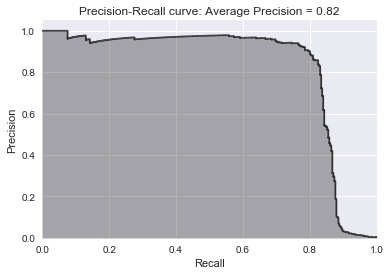

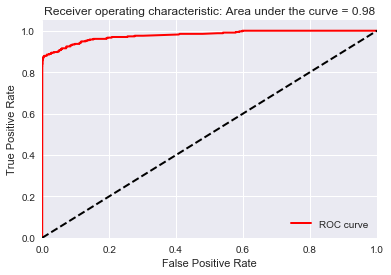

In [61]:
preds = pd.concat([y_train,predictionsBasedOnKFoldsEnsemble.loc[:,'prediction']], axis=1)
preds.columns = ['trueLabel','prediction']

precision, recall, thresholds = precision_recall_curve(preds['trueLabel'],preds['prediction'])
average_precision = average_precision_score(preds['trueLabel'],preds['prediction'])

plt.step(recall, precision, color='k', alpha=0.7, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.3, color='k')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

plt.title('Precision-Recall curve: Average Precision = {0:0.2f}'.format(
          average_precision))

fpr, tpr, thresholds = roc_curve(preds['trueLabel'],preds['prediction'])
areaUnderROC = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='k', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic: Area under the curve = {0:0.2f}'.format(
          areaUnderROC))
plt.legend(loc="lower right")
plt.show()

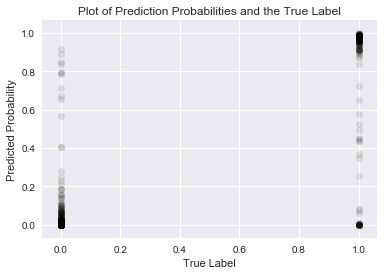

In [64]:
scatterData = predictionsTestSetLightGBMGradientBoosting.join(y_test,how='left')
scatterData.columns = ['Predicted Probability','True Label']
ax = sns.regplot(x="True Label", y="Predicted Probability", color='k', 
                 fit_reg=False, scatter_kws={'alpha':0.1},
                 data=scatterData).set_title('Plot of Prediction Probabilities and the True Label')

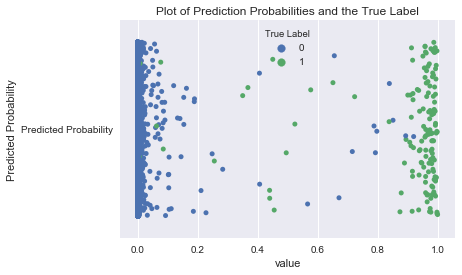

In [65]:
scatterDataMelted = pd.melt(scatterData, "True Label", var_name="Predicted Probability")
ax = sns.stripplot(x="value", y="Predicted Probability", hue='True Label', jitter=0.4,
                 data=scatterDataMelted).set_title('Plot of Prediction Probabilities and the True Label')

In [ ]:
'''Pipeline for New Data'''
# first, import new data into a dataframe called 'newData'
# second, scale data -- newData.loc[:,featuresToScale] = sX.transform(newData[featuresToScale])
# third, predict using LightGBM -- gbm.predict(newData, num_iteration=gbm.best_iteration)